# Audio Spectrum Display Simulation
This notebook is used to generate sinewayes samples to use them for testing in embedded system. Samples are then transformed using FFT and then visualise. The bins-bands LUT is evaluated. Then tests are made. Signal is processed on STM32F4 then it is compared with visualization. Thresholding is used to remove noise in frequency domain and then reconstructed. Comparison is dome. Then DAC is used to generate sine wave with variable frequency.

For further informations check out [Github](https://github.com/Gieneq/Spectrum_Audio_Display_V2)

## Assumptions

* Sampling frequency: 44 kHz (it can sligtly change depending on available hardware resources),
* Max frequency in the signal (Nyquist theorem): 22 kHz,
* Numbber of FFT samples: 1024,
* Numbber of FFT bins: 512 (half of FFT samples),
* Number of bands: 19,
* Bins to bands assignment function: exponential with variable exponent factor.

The goal is to achieve FFT refreshrate of not **less then 30 Hz**. STM32F4 IC will be used to sample signal with builtin 12 bit ultra-fast SAR ADC.

To let hardware ADC sampling and simultenously evaluating FFT double buffering is done. Toal length of samples buffer: 2048. When half of buffer is filled interrupt is invoken to trigger FFT. Only one half of samples is used to evaluate FFT. Evaluation time cannot exceed sampling time.



In [219]:
sampling_frequency = 44e3  # Hz
refresh_rate_cap = 30      # Hz

# Sampling time
More FFT points means longer sampling time. By using 44 kHz sampling rate the overall refresh rate can drop below 30 Hz cap quite fast. It can be avoided by double buffering samples and windowing. In comparison the time of evaluating the FFT on STM32 using the CMSIS library is neglibli short (see further).

Considered FFT resolution: [128, 256, 512, 1024, 2048, 4096]
Refresh rate cap: {128: 344, 256: 172, 512: 86, 1024: 43, 2048: 21, 4096: 11} [points:Hz]
Max FFT points: 1024 with 43 Hz refresh rate.


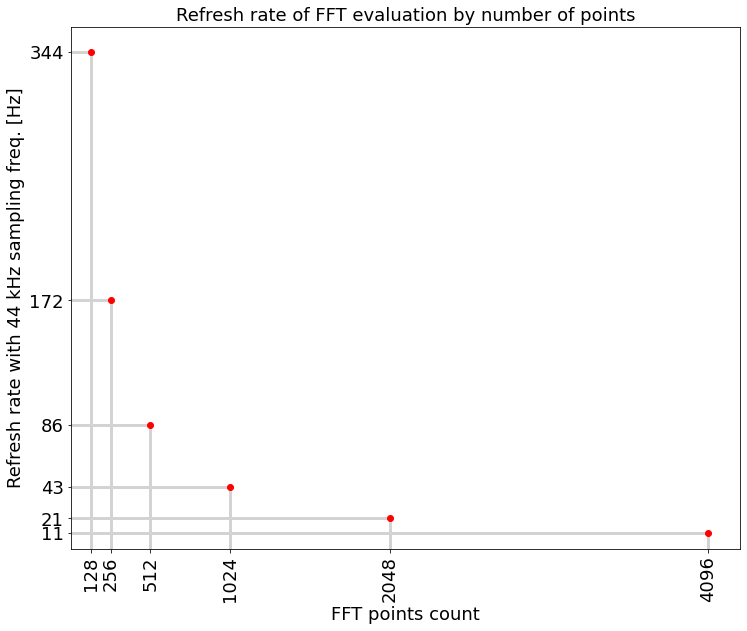

In [220]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import pi, floor

plots_scale = 0.8
plt.rcParams['figure.figsize'] = [plots_scale*15, plots_scale*12]

fft_points_options = [2**i for i in range(7,13)]
print(f"Considered FFT resolution: {fft_points_options}")
sampling_time = [1000*points/sampling_frequency for points in fft_points_options]
point_fps_dict = dict(zip(fft_points_options, [round(sampling_frequency/points) for points in fft_points_options]))
freqs_by_ftt_points = list(point_fps_dict.values())
print(f"Refresh rate cap: {point_fps_dict} [points:Hz]")

inv_point_fps_dict = dict(zip(point_fps_dict.values(), point_fps_dict.keys()))
available_options = sorted({val:key for key, val in point_fps_dict.items() if val > refresh_rate_cap}.items(), reverse=False, key=lambda x: x[0])
best_option = available_options[0]
print(f"Max FFT points: {best_option[1]} with {best_option[0]} Hz refresh rate.")


for x, y in zip(fft_points_options, freqs_by_ftt_points):
    plt.plot([x, x],[0,y], color='lightgray', linestyle='-', linewidth=3)
    plt.plot([0, x],[y,y], color='lightgray', linestyle='-', linewidth=3)
    
plt.plot(fft_points_options, freqs_by_ftt_points, "or")

plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xticks(fft_points_options, rotation=90, fontsize= 18)
plt.yticks(freqs_by_ftt_points, fontsize= 18)

plt.xlabel("FFT points count", fontsize=18)
plt.ylabel(f'Refresh rate with {round(sampling_frequency/1000)} kHz sampling freq. [Hz]', fontsize=18)
plt.title(f"Refresh rate of FFT evaluation by number of points", fontsize=18)
plt.show()


## Example results - FFT evaluation time

```
START INPUT SIGNAL 1024:
0.162400, -0.028700, -0.098300, -0.018800, 0.012700, -0.109700, 0.101200, 0.044800, -0.009300, 0.067600, 0.161000, -0.159100, 0.047500, -0.037000, 0.249000, -0.136800, 0.150300, -0.114000, 0.172100, 0.064200, 0.029300, 0.176400, 0.184000, 0.177100, 0.138400, 0.114300, 0.007700, 0.120900, -0.006000, 0.267700, -0.016300, 0.146400, 0.040200, 0.055900, 0.106700, 0.093600, 0.117800, 0.090100, 0.427100, 0.141600, 0.242100, 0.010800, 0.157800, 0.324800, 0.191800, 0.156700, 0.160300, 0.486000, 0.125000, 0.369200, 0.143700, 0.272200, 0.031600, 0.243600, 0.181000, 0.291300, 0.350400, 0.280100, 0.350600, 0.247300, 0.277900, 0.284800, 0.404400, 0.161800, 0.372900, 0.240000, 0.391200, 0.464200, 0.450900, 0.227900, 0.059600, 0.348200, 0.220800, 0.485800, 0.268400, 0.166700, 0.262100, 0.405600, 0.380200, 0.353200, 0.390100, 0.228600, 0.461900, 0.290300, 0.462400, 0.293300, 0.346100, 0.374900, 0.379100, 0.514400, 0.440800, 0.475000, 0.255000, 0.423200, 0.335500, 0.494000, 0.290700, 0.460900, 0.318800, 0.479900, 0.400200, 0.486500, 0.540100, 0.394900, 0.420600, 0.353000, 0.603000, 0.272600, 0.472500, 0.426800, 0.315100, 0.519000, 0.490800, 0.456100, 0.412600, 0.440900, 0.374100, 0.409200, 0.521900, 0.581500, 0.462700, 0.416200, 0.656400, 0.644100, 0.397500, 0.542200, 0.775900, 0.452700, 0.491500, 0.536900, 0.563000, 0.445400, 0.410900, 0.624500, 0.566700, 0.561100, 0.510500, 0.538600, 0.538900, 0.655700, 0.471500, 0.610200, 0.632200, 0.648000, 0.661600, 0.540000, 0.670200, 0.559000, 0.714900, 0.565400, 0.658300, 0.285100, 0.762200, 0.802100, 0.654800, 0.636600, 0.550100, 0.688100, 0.536200, 0.616800, 0.482700, 0.626600, 0.590500, 0.665300, 0.669800, 0.629600, 0.781800, 0.621200, 0.955400, 0.380800, 0.700200, 0.660300, 1.014700, 0.576300, 0.734600, 0.633000, 0.815200, 0.689500, 0.702600, 0.739100, 0.477700, 0.830700, 0.654800, 0.925300, 0.624300, 0.702200, 0.745800, 0.739500, 0.779900, 0.660400, 0.920400, 0.674800, 1.022700, 0.748300, 0.894400, 0.505100, 0.856300, 0.763800, 0.828400, 0.888300, 0.659200, 0.918400, 0.613000, 1.058900, 0.535100, 0.683200, 0.533600, 0.737500, 0.640500, 0.973100, 0.781500, 0.594900, 0.977400, 0.640200, 0.769300, 0.785300, 0.950800, 0.684400, 0.996100, 0.794200, 0.967600, 0.893000, 0.913200, 0.905100, 0.604800, 1.165700, 0.670800, 0.896000, 0.685200, 0.862000, 0.832700, 0.852700, 0.935600, 0.962900, 0.908500, 0.629500, 0.828500, 0.684600, 0.774000, 0.863300, 0.857700, 0.802600, 0.857100, 0.754700, 0.722000, 1.012500, 0.838800, 0.926600, 0.956200, 0.834500, 0.770000, 0.907700, 0.577700, 1.073900, 0.954000, 0.726200, 1.172700, 0.857800, 1.036000, 0.736400, 0.997400, 0.673600, 1.031500, 0.841000, 0.914500, 1.058600, 0.879700, 1.014500, 0.847200, 0.939900, 0.900700, 1.160800, 0.921800, 1.059800, 0.810100, 0.833200, 0.813400, 0.993000, 0.981400, 0.977700, 0.953100, 0.791300, 1.033700, 0.955700, 0.994600, 0.936300, 0.938500, 0.992100, 0.774600, 1.031500, 0.835300, 1.041700, 0.900200, 0.971700, 0.870700, 0.974000, 0.972200, 1.030000, 0.893700, 0.959300, 1.244400, 0.720900, 0.978400, 0.776700, 1.025300, 1.054900, 1.018100, 0.874100, 1.026400, 0.942000, 1.025300, 1.080600, 1.018900, 1.007100, 1.179500, 1.147100, 0.969400, 1.022500, 0.882000, 0.887900, 0.999000, 0.843300, 1.088500, 0.807200, 1.145000, 0.981500, 1.003200, 1.032400, 1.012600, 1.078900, 1.026800, 1.133300, 0.831300, 1.057500, 1.042500, 1.028600, 0.689500, 0.886500, 0.669500, 0.831500, 0.928800, 1.116900, 0.983000, 0.969100, 1.063000, 0.903700, 1.078800, 0.880900, 1.131700, 0.807300, 1.148300, 1.066400, 0.973500, 1.111800, 0.870100, 1.023800, 0.921600, 1.079700, 0.856300, 1.020900, 0.871700, 1.143300, 0.782300, 1.029900, 1.009400, 1.014400, 1.130400, 0.628700, 1.158000, 0.934300, 1.090700, 0.881000, 1.134600, 0.935300, 1.177600, 1.089100, 1.154500, 0.999500, 0.730200, 1.169700, 0.985600, 1.090200, 0.772100, 1.002100, 1.036200, 0.973000, 1.018400, 0.920000, 0.981500, 0.849000, 0.952000, 1.073300, 1.035100, 0.969600, 0.940200, 1.049400, 0.799100, 1.117200, 0.928700, 1.280700, 0.766000, 1.096500, 0.927300, 1.199600, 0.873300, 1.044300, 0.749000, 0.896300, 1.063200, 1.035100, 1.033900, 1.094400, 1.256900, 0.876300, 0.826500, 0.729300, 0.948900, 1.066000, 1.001000, 0.799400, 0.892100, 1.213700, 0.841300, 0.995700, 1.077500, 1.062600, 0.848500, 1.050600, 0.945100, 0.915500, 1.118300, 1.014700, 1.124600, 0.856200, 1.173000, 0.854600, 1.091100, 0.987000, 1.083300, 1.109200, 0.989900, 0.815500, 0.773100, 1.161600, 0.819100, 1.082600, 0.759800, 1.129600, 0.830200, 1.132800, 0.861800, 1.040800, 1.035700, 0.800800, 1.120400, 0.745600, 0.945100, 0.900400, 0.949900, 0.792300, 0.935200, 0.797600, 1.015700, 1.011300, 0.847900, 0.981500, 0.862300, 1.185300, 0.896500, 0.942600, 0.910300, 0.938200, 0.858400, 1.077900, 0.888800, 0.786700, 0.776900, 0.656500, 1.033200, 0.719200, 1.023900, 0.700000, 0.851800, 0.924300, 1.015500, 0.968200, 0.932200, 1.120400, 0.878300, 0.873700, 0.755400, 1.012300, 0.747000, 0.950300, 0.675600, 0.762700, 0.938200, 0.564500, 0.815100, 0.748100, 0.769100, 0.746900, 0.844400, 0.734400, 0.853800, 0.827200, 0.763500, 0.868700, 0.702100, 0.955500, 0.893000, 0.934300, 0.731700, 0.781100, 0.806100, 0.776700, 0.700300, 0.848100, 0.850400, 0.845100, 1.016400, 0.641500, 0.899200, 0.862400, 0.965600, 0.779500, 0.954200, 0.691900, 0.826600, 0.944000, 0.866800, 0.762000, 0.640500, 0.894700, 0.627400, 0.799400, 0.746300, 0.757500, 0.543000, 0.768100, 0.729800, 0.600300, 0.654800, 0.735500, 0.602100, 0.454600, 0.779000, 0.768800, 0.891400, 0.574100, 0.681500, 0.588700, 0.741600, 0.630800, 0.586600, 0.894900, 0.568900, 0.920000, 0.525300, 0.763400, 0.741100, 0.651000, 0.844200, 0.660800, 0.580300, 0.962100, 0.821700, 0.567000, 0.598000, 0.585400, 0.645100, 0.684900, 0.666400, 0.855300, 0.584300, 0.759500, 0.567300, 0.705700, 0.501600, 0.811400, 0.618800, 0.591200, 0.472400, 0.585400, 0.749200, 0.529900, 0.845500, 0.415000, 0.697100, 0.230600, 0.603800, 0.472000, 0.667000, 0.716700, 0.557100, 0.740100, 0.560100, 0.730900, 0.407000, 0.782600, 0.335900, 0.673600, 0.368500, 0.524600, 0.360200, 0.462200, 0.590300, 0.447200, 0.457700, 0.560700, 0.637700, 0.503900, 0.662200, 0.356900, 0.341200, 0.374300, 0.595500, 0.409100, 0.494600, 0.490300, 0.411700, 0.380300, 0.478500, 0.538200, 0.470600, 0.513000, 0.504100, 0.420800, 0.547100, 0.219900, 0.401400, 0.402700, 0.516500, 0.296500, 0.481700, 0.389700, 0.391900, 0.432800, 0.296500, 0.389300, 0.426200, 0.573700, 0.177300, 0.561100, 0.172300, 0.529500, 0.106400, 0.295800, 0.287400, 0.327600, 0.528800, 0.374200, 0.580300, 0.363600, 0.404900, 0.205500, 0.518800, 0.256100, 0.347400, 0.160500, 0.289000, 0.062900, 0.193500, 0.280200, 0.267400, 0.340600, 0.154400, 0.501700, 0.102300, 0.349600, 0.059600, 0.263300, 0.338000, 0.279700, 0.243100, 0.184700, 0.374900, 0.139900, 0.336400, 0.208100, 0.311900, 0.104000, 0.088800, 0.501900, 0.339700, 0.148000, 0.151800, 0.359800, 0.171000, 0.289300, 0.023100, 0.207600, 0.108500, 0.175500, 0.178400, 0.088200, 0.342800, 0.183400, 0.132600, 0.003500, 0.149600, 0.191800, 0.173300, 0.256100, 0.067500, 0.161400, -0.080300, 0.324600, -0.022600, 0.055500, -0.056500, -0.048700, 0.019500, 0.143500, 0.093300, 0.218100, 0.081900, 0.088300, 0.178700, -0.052700, -0.050700, 0.050600, 0.084300, -0.022400, -0.042000, 0.045900, 0.031900, 0.068000, -0.053100, 0.205500, 0.016100, 0.182500, 0.240900, 0.027500, -0.109100, -0.063700, 0.014200, -0.095000, -0.251700, -0.208200, 0.060700, -0.026700, -0.092900, -0.199600, 0.026400, -0.191000, 0.043700, -0.075900, -0.041300, -0.101300, 0.019600, 0.006500, -0.045400, -0.028100, -0.126300, -0.074700, -0.260100, -0.127000, -0.127700, -0.142400, 0.078300, -0.296000, -0.149300, -0.051700, 0.029800, -0.420200, -0.003900, -0.188000, -0.317900, -0.206600, -0.169200, -0.049000, -0.132400, -0.077200, -0.165000, -0.092200, -0.364300, -0.193600, -0.203800, -0.345800, -0.148100, -0.324600, -0.204200, -0.223700, -0.011100, -0.508600, -0.204400, -0.319700, -0.205900, -0.217800, -0.404800, -0.225500, -0.217400, -0.209100, -0.210000, -0.301600, -0.249500, -0.239700, -0.297700, -0.224400, -0.267900, -0.163700, -0.453400, -0.320900, -0.268400, -0.389400, -0.299300, -0.220400, -0.193600, -0.259700, -0.293900, -0.500300, -0.273500, -0.407900, -0.111300, -0.279100, -0.295000, -0.290500, -0.482600, -0.261900, -0.423900, -0.196400, -0.450400, -0.399000, -0.502200, -0.402100, -0.290100, -0.408400, -0.313500, -0.553700, -0.287700, -0.445700, -0.328500, -0.470100, -0.389400, -0.346900, -0.481500, -0.371700, -0.457800, -0.282000, -0.386900, -0.277500, -0.485500, -0.514400, -0.463000, -0.187400, -0.563500, -0.581900, -0.453600, -0.437200, -0.343800, -0.626000, -0.390400, -0.483300, -0.341700, -0.322100, -0.357700, -0.486200, -0.459800, -0.507900, -0.678100, -0.419800, -0.570000, -0.566900, -0.679700, -0.486400, -0.578600, -0.524600, -0.517000, -0.551600, -0.406700, -0.791400, -0.310900, -0.516900, -0.461800, -0.601700, -0.428100, -0.717900, -0.521200, -0.522400, -0.569300, -0.446100, -0.649400, -0.506800, -0.773800, -0.541400, -0.750800, -0.356200, -0.657800, -0.675500, -0.597800, -0.657100, -0.893800, -0.648200, -0.707200, -0.676200, -0.638000, -0.887300, -0.514000, -0.867600, -0.656700, -0.653300, -0.612900, -0.549800, -0.735800, -0.670800, -0.577200, -0.637800, -0.596300, -0.643900, -0.636900, -0.540000, -0.812900, -0.673400, -0.583000, -0.696500, -0.641500, -0.773500, -0.650600, -0.927600, -0.534000, -0.842400, -0.542500, -0.681100, -0.831400, -0.707400, -0.828100, -0.741200, -0.786100, -0.691300, -0.679400, -0.578400, -0.906200, -0.714300, -0.795500, -0.930200, -0.629300, -0.735800, -0.592500, -0.912800, -0.567200, -0.894000, -0.601500, -0.667100, -0.728600, -0.944400, -0.835300, -0.687800, -0.738300, -0.827600, -0.915300, -0.679800, -0.858300, -0.632600, -0.971500, -0.813400, -0.729700, -0.792500, -0.734800, -0.775600, -0.731300, -0.870900, -0.761700, -1.063300, -0.880100, -0.895800, -0.817700, -0.922200, -0.826300, -0.894500, -0.902900, -0.769200, -1.033200, -0.985400, -0.808200, -0.744000, -1.194300, -0.865200, -0.841700, -0.905400, -0.771400, -1.035500, -0.773400, -0.978200, -0.797400, -0.999200, -0.778900, -0.857500, -0.898400, -0.944200, -0.889000, -0.863500, -0.921700, -0.740900, -0.865500, -0.812200, -1.226100, -0.827000, -0.936200, -0.885000, -0.939200, -1.168900, -0.820800, -1.012800, -0.983600, -1.101400, -0.906500, -0.956700, -0.783100, -0.838900, -0.820400, -1.077400, -1.085100, -0.776600, -0.841900, -0.874000, -0.976100, -0.987900, -1.229200, -0.973800, -1.042800, -0.954100, -0.981600, -1.009700,
STOP INPUT SIGNAL

START MAGNITUDES 512:
311.611298, 420.973175, 98.181526, 58.793087, 42.696358, 34.219872, 27.166374, 22.050308, 23.350767, 17.923510, 15.884156, 14.196798, 12.315430, 9.619698, 10.180439, 9.000499, 8.794942, 10.502289, 10.525803, 5.502507, 11.198858, 4.921964, 7.806212, 7.191403, 13.103984, 4.411048, 9.950627, 6.397113, 6.724702, 3.149494, 4.520862, 0.664049, 4.605950, 7.379102, 6.352910, 2.922272, 4.049648, 2.794556, 4.907353, 6.023583, 4.442853, 4.770113, 3.483039, 5.503522, 5.699846, 3.876783, 1.585827, 6.080563, 4.394556, 5.090203, 4.273499, 8.033374, 3.431290, 7.954720, 4.478786, 5.276656, 1.755860, 6.411362, 4.088744, 7.676416, 5.302637, 1.619808, 3.830848, 4.266191, 2.371081, 0.721831, 9.798796, 2.184896, 2.417721, 5.953014, 1.730970, 3.199516, 4.529813, 4.787174, 2.330813, 1.399504, 4.666001, 3.025300, 1.151932, 1.630097, 4.041630, 2.738845, 0.874528, 3.313502, 2.371997, 4.394870, 0.670934, 2.108423, 4.651202, 2.259524, 2.569243, 3.095037, 1.012516, 9.095780, 2.255078, 2.060739, 3.255676, 1.839227, 1.201043, 0.656192, 0.344227, 0.919925, 3.903918, 1.451457, 2.187972, 5.005841, 1.389268, 4.049835, 6.730608, 3.906466, 3.550928, 1.838502, 4.911197, 3.713193, 1.706646, 4.168273, 2.137857, 1.580663, 5.046528, 2.038693, 3.074535, 2.210383, 0.665107, 4.335557, 1.970870, 3.833963, 2.198509, 2.750386, 4.946528, 4.398332, 2.094601, 2.501239, 3.501737, 4.771334, 2.758805, 0.688399, 3.031360, 3.176671, 2.043063, 1.315872, 4.404724, 3.635988, 2.267796, 3.547916, 3.010217, 1.114893, 1.998764, 1.588649, 5.220007, 2.283391, 3.772204, 1.255955, 2.806586, 4.184934, 1.599002, 4.837073, 3.510461, 0.411965, 3.603539, 3.139255, 2.788831, 1.286358, 4.494002, 4.366319, 3.473316, 3.046870, 6.424746, 1.565140, 1.244373, 2.649535, 1.698998, 1.719336, 1.789892, 4.011186, 3.685741, 3.417784, 4.670474, 1.473895, 2.395444, 7.770602, 0.582429, 3.310256, 1.458363, 1.365618, 3.354419, 1.959573, 6.545698, 4.382027, 2.853459, 2.403546, 1.807798, 2.680995, 1.993848, 2.033995, 1.905783, 2.921513, 2.958173, 2.770745, 2.948903, 4.884269, 2.779727, 6.958907, 1.435383, 3.219201, 1.210576, 2.218783, 1.257496, 5.513084, 4.272650, 2.899375, 2.189182, 2.827973, 0.567151, 6.091878, 4.128782, 2.568902, 4.532327, 2.104870, 4.522021, 3.024946, 5.440111, 4.348938, 4.755376, 3.484576, 1.315659, 1.650539, 2.503297, 5.861333, 4.897120, 3.281852, 1.924014, 1.237925, 0.502206, 1.696262, 3.899023, 4.874426, 1.718424, 3.369154, 3.030799, 2.822410, 1.958753, 2.394849, 3.582337, 4.587001, 2.123251, 0.636817, 3.649687, 1.296156, 2.768515, 3.881472, 1.646296, 3.170049, 1.050683, 1.940674, 3.487895, 3.637708, 1.794615, 5.815289, 1.775288, 2.954899, 1.872904, 2.488930, 2.296425, 1.423059, 3.032474, 2.637573, 2.175856, 3.846042, 3.937070, 2.888401, 6.957985, 0.742949, 4.712399, 1.912692, 1.347914, 5.876383, 3.198382, 1.793628, 1.964006, 3.079350, 2.970970, 3.823082, 3.719612, 3.739702, 1.802258, 2.562800, 4.460296, 1.217795, 2.623007, 2.077900, 1.772341, 4.761983, 4.971382, 1.839666, 4.253601, 0.905512, 2.071765, 1.118139, 2.535856, 4.808728, 1.797674, 2.373426, 1.579288, 4.178109, 4.422516, 4.222070, 1.872161, 5.345586, 0.662588, 5.061263, 3.813539, 2.871368, 3.164520, 1.473660, 2.571348, 1.907749, 3.773250, 1.218611, 3.717185, 3.307452, 5.330945, 1.640526, 0.122820, 2.219406, 1.726396, 5.112490, 2.115767, 1.201189, 4.382419, 5.321987, 0.395452, 4.479269, 1.021623, 3.946578, 1.451532, 0.910867, 2.509657, 1.916169, 0.634124, 2.567833, 2.261234, 2.930490, 1.456604, 4.421792, 2.410108, 1.127875, 2.761534, 3.970270, 3.196306, 3.659320, 0.569745, 3.783265, 5.087133, 3.178225, 2.970014, 4.664773, 3.125005, 5.820123, 2.376634, 1.505884, 3.890745, 2.935335, 1.569663, 1.535686, 4.893541, 1.604228, 2.057036, 3.546638, 2.795932, 3.531912, 4.498040, 2.181052, 5.471846, 2.531549, 2.556983, 3.557651, 4.400565, 2.778634, 2.094877, 0.092620, 2.328625, 2.147627, 4.240350, 1.025002, 3.390504, 1.896171, 2.931432, 3.284865, 3.005916, 0.564143, 5.071870, 1.990580, 5.393910, 3.231824, 1.643514, 1.205639, 3.196619, 3.874708, 2.794814, 2.197352, 5.174702, 1.976470, 4.712466, 2.310155, 4.616511, 1.604155, 3.783131, 2.144627, 0.426026, 1.759130, 2.981774, 2.306149, 3.700000, 2.740825, 5.122342, 1.552353, 0.724058, 4.397523, 2.008843, 2.694848, 1.519898, 2.224115, 2.414276, 2.061995, 5.864852, 1.482071, 0.810557, 1.144947, 4.103496, 1.277274, 3.384162, 3.524052, 3.579049, 3.947427, 2.871200, 3.123855, 1.943913, 1.636981, 4.965639, 0.338467, 0.028780, 1.629543, 0.715985, 2.908747, 3.322578, 1.755031, 1.132097, 4.427827, 1.503237, 3.459395, 3.109643, 1.921192, 3.364445, 4.757797, 4.466207, 4.995214, 2.477515, 1.026182, 3.895605, 4.241823, 5.083951, 3.064636, 5.347758, 6.645368, 9.015448, 34.896545, 25.890478, 8.666534, 7.351264, 2.618441, 3.861533, 5.237008, 5.464644, 6.046464, 3.057974, 2.467849, 1.448885, 2.291913, 3.425291, 4.936892, 6.065387, 3.384300, 6.105838, 4.612744, 3.404362, 0.392055, 5.132501, 5.871990, 0.564263, 1.407465, 1.765660, 2.113817, 6.460523, 3.503680, 4.162999, 5.991980, 2.406905, 1.475230, 3.360773, 1.334891, 4.145240, 2.649426, 1.587526, 0.645034, 3.067425, 5.699400, 3.616920, 3.019164, 2.327585, 1.561591, 0.429032, 5.108437,
STOP MAGNITUDES

START REAL 1024:
311.611298, -292.625244, -42.907005, -22.194689, -11.453762, -5.754398, -4.920623, -1.781957, -7.162320, -2.998394, -0.726078, 0.682367, 0.495269, -1.052336, 1.215669, -2.128953, 1.661377, -2.228601, 0.329934, 0.775770, -0.313245, -1.929369, 0.377885, 1.465248, 0.496240, -2.655761, -0.771508, 3.092270, 2.422315, 0.107368, -2.131090, 0.223483, -1.882649, 2.654434, -1.654583, 2.098518, 2.024106, -1.686486, 1.296338, -5.411964, -4.031675, 2.383361, 1.513209, -0.841195, 1.777523, -2.518124, 0.373216, 0.171335, 2.340304, 2.677005, 3.743984, -3.690600, 1.427085, 2.884010, -3.249595, 1.027476, -1.527872, 0.491883, -3.039155, 3.375965, 1.864916, 1.039497, 1.388837, 1.076570, -2.362334, -0.721272, 3.830387, 1.738976, -1.412025, 1.639094, -1.728061, -1.349480, 3.445386, 0.250504, 2.255381, 1.350081, -1.149675, 2.891124, -0.849592, 1.335959, 4.041578, -1.751139, 0.842138, -0.469274, 2.360181, -0.502625, 0.003524, 1.304855, 0.406382, 1.179369, 1.752008, 2.876459, 0.929752, 3.930071, 1.138327, -1.423446, -0.644100, 1.079174, 1.156588, 0.539057, -0.060991, -0.307654, 2.898792, -1.446284, -2.137587, 3.635488, 0.143959, 3.872165, 1.803932, 1.393999, 2.651367, -0.196923, 4.876979, 0.640091, 0.955009, -2.259264, -1.237029, -0.587247, 0.034412, -1.240956, 2.416647, -0.491878, 0.202686, 4.139500, 0.884916, -2.083243, 1.864353, 2.320971, 4.774825, 4.304926, -2.086738, 2.472476, 1.970929, 2.485559, 0.171447, -0.678633, 2.484445, 3.176571, 1.301530, -1.212439, 4.391558, 2.202036, 1.151212, 2.463017, -0.732129, 0.598465, -1.801321, 1.250752, -3.713418, -2.179866, 2.550830, 1.051983, 2.191556, -4.143819, 1.545613, -1.662811, -0.465166, 0.091553, -2.726326, 2.938906, -2.638760, 0.313609, 4.357162, -1.618214, -2.506861, 1.098318, 4.198050, -0.653863, -0.759810, -1.387710, 0.452343, 1.666125, 1.789890, -1.513576, -1.418706, 0.531040, -3.295039, -0.418501, 0.208320, -5.953188, -0.194434, 2.920175, 0.808302, -0.432560, 2.384996, 0.773746, 3.685921, 0.914651, 0.227699, 0.527597, -1.699550, 2.544930, 1.330034, -1.487853, -1.283374, 2.639940, 2.958005, 0.491723, -0.494525, 4.226021, -0.456320, 5.773912, 0.903852, 0.315787, -1.097833, -2.000161, -0.119621, 1.660769, 4.188684, -0.611757, 2.043187, 2.111385, 0.069690, 5.580765, 2.615927, -0.074951, 1.208638, 2.028624, -2.554395, 1.880265, -5.426829, 4.238167, -1.181203, 0.153813, 1.090545, -0.743924, 1.591446, 2.939580, 4.746238, 2.063825, -1.397007, 0.427139, -0.386370, -0.470084, 0.227501, 2.071660, -1.058452, -1.143022, 2.891825, 2.632542, 0.381553, 2.343987, 1.789631, 4.086557, 0.844520, 0.597589, 2.609925, -0.042795, -1.924085, -3.831443, 1.563949, 2.608068, 0.801798, 1.560269, -2.449730, -2.713486, 1.128494, -5.815285, -1.501616, 2.717874, -1.757338, 1.577791, -0.294221, 0.596548, 1.066467, -2.610956, -2.121713, 3.440333, 3.553398, 1.522823, 5.456658, 0.593034, -3.272110, 0.863917, -1.204036, 5.299626, -1.310063, 1.709102, -0.892331, 0.444798, -0.449919, 2.789773, 0.726468, 3.193794, 1.779721, 2.085948, 4.287406, -0.373145, 1.475723, -2.042904, 1.056243, 4.734046, 4.507919, -0.747666, 3.892265, 0.559079, -1.947878, -0.557660, 1.816730, -0.245814, -0.326808, -0.527961, 0.629118, 4.177204, 4.340639, -3.405348, 1.282085, 3.009815, 0.185511, 4.596805, 0.774231, 1.318826, -2.540918, 0.766229, -0.549441, 1.585419, 2.111194, -1.114295, 2.107270, 3.204798, -4.979491, 0.647622, -0.102446, 1.254030, -0.636261, -0.776772, 1.927064, -1.200150, 4.381665, 3.839912, 0.389654, 4.475789, -0.108751, 3.924702, 1.315099, -0.454745, 0.956469, -1.165458, -0.219145, -0.040312, -2.243984, -0.819291, -0.728291, 1.730365, -0.448670, 0.977211, -0.258871, 1.977028, 1.399404, 2.806057, -0.329494, 3.713469, 3.646910, 2.033436, -2.331798, -0.266465, -1.696428, -1.536832, -0.025444, 1.502364, -1.439382, 0.588186, 0.899143, -0.990190, 0.649631, 0.484978, 1.499596, -1.665691, 1.863716, -2.382792, -0.269420, -1.739990, 4.847990, 1.446013, -1.450150, 3.294058, 2.802518, 1.826992, 1.943910, -0.052573, -1.682224, 0.882728, 3.800284, 0.361146, 3.158372, -0.627422, 2.928541, -1.891828, 2.926149, -0.434347, 4.133577, 1.401852, 5.323957, -2.893291, -1.189430, 1.204397, -0.542096, 3.400132, -2.793236, -1.394950, 2.462317, 0.400955, -4.602022, -0.174677, 0.231754, 1.256563, 3.687465, -1.428089, -0.317405, -1.755073, -1.855487, -2.161357, -3.037103, 2.728755, 5.007302, 1.424175, 0.321543, 4.255516, 0.452085, 0.323111, -1.043195, 0.872690, 0.314171, 1.856775, 5.581878, -1.014213, -0.810145, 0.331060, 0.125656, -0.060751, 2.992653, -2.000724, 2.865522, 3.935015, 1.606526, 0.711375, 1.939897, 1.605752, 0.977372, 0.320430, 0.026153, 1.230233, 0.007152, -0.899058, 3.322275, 0.519220, 0.879247, -4.407917, -0.786205, 2.859600, 0.577897, 0.075982, 0.273736, 4.742134, 3.805999, -4.016666, 2.175663, -0.545627, 3.653893, 4.241820, 4.597775, 0.399231, 5.050837, 6.459835, 8.878182, 34.148865, -25.818802, -7.280944, -6.746828, -2.504431, 1.220023, -5.222439, -5.416531, -1.285609, -0.484950, -2.379953, 0.793757, 0.442787, -2.982949, 3.826486, -3.714015, -2.023714, 0.412637, -4.011794, 3.383533, 0.343728, 1.580173, 0.861278, 0.109824, -0.887007, -1.614865, -1.877780, 2.193408, 2.974956, -1.598517, 3.394705, -0.058844, -1.371399, 1.355451, 1.141469, 4.132510, 2.450890, -0.191219, -0.157688, 2.924331, 1.261854, 1.655912, -0.200484, 2.187258, -1.085905, -0.297886, 5.030472, 0.886902, 5.030472, -0.297886, -1.085903, 2.187259, -0.200482, 1.655912, 1.261854, 2.924331, -0.157690, -0.191218, 2.450892, 4.132511, 1.141470, 1.355450, -1.371403, -0.058844, 3.394703, -1.598518, 2.974955, 2.193408, -1.877781, -1.614864, -0.887006, 0.109823, 0.861281, 1.580172, 0.343728, 3.383533, -4.011796, 0.412637, -2.023713, -3.714015, 3.826490, -2.982950, 0.442787, 0.793757, -2.379953, -0.484950, -1.285606, -5.416531, -5.222439, 1.220023, -2.504430, -6.746828, -7.280944, -25.818802, 34.148865, 8.878182, 6.459834, 5.050836, 0.399231, 4.597775, 4.241820, 3.653893, -0.545626, 2.175663, -4.016665, 3.805999, 4.742132, 0.273735, 0.075982, 0.577897, 2.859607, -0.786205, -4.407922, 0.879246, 0.519221, 3.322274, -0.899059, 0.007152, 1.230232, 0.026153, 0.320430, 0.977372, 1.605752, 1.939897, 0.711376, 1.606525, 3.935016, 2.865522, -2.000723, 2.992653, -0.060753, 0.125656, 0.331060, -0.810145, -1.014213, 5.581878, 1.856775, 0.314171, 0.872689, -1.043195, 0.323113, 0.452084, 4.255513, 0.321543, 1.424176, 5.007302, 2.728759, -3.037102, -2.161357, -1.855487, -1.755072, -0.317405, -1.428089, 3.687465, 1.256564, 0.231754, -0.174679, -4.602021, 0.400957, 2.462317, -1.394946, -2.793236, 3.400129, -0.542096, 1.204395, -1.189430, -2.893290, 5.323956, 1.401854, 4.133576, -0.434347, 2.926149, -1.891826, 2.928540, -0.627437, 3.158372, 0.361135, 3.800284, 0.882726, -1.682225, -0.052573, 1.943909, 1.826991, 2.802518, 3.294061, -1.450150, 1.446015, 4.847990, -1.739990, -0.269419, -2.382793, 1.863716, -1.665690, 1.499597, 0.484979, 0.649632, -0.990190, 0.899143, 0.588184, -1.439381, 1.502363, -0.025444, -1.536832, -1.696428, -0.266463, -2.331799, 2.033432, 3.646911, 3.713476, -0.329494, 2.806057, 1.399404, 1.977026, -0.258871, 0.977213, -0.448670, 1.730366, -0.728291, -0.819291, -2.243983, -0.040312, -0.219144, -1.165462, 0.956469, -0.454746, 1.315099, 3.924702, -0.108751, 4.475790, 0.389653, 3.839912, 4.381664, -1.200153, 1.927064, -0.776772, -0.636261, 1.254030, -0.102446, 0.647624, -4.979491, 3.204794, 2.107269, -1.114298, 2.111194, 1.585417, -0.549441, 0.766228, -2.540918, 1.318828, 0.774231, 4.596805, 0.185511, 3.009819, 1.282085, -3.405351, 4.340639, 4.177201, 0.629117, -0.527960, -0.326808, -0.245814, 1.816729, -0.557661, -1.947878, 0.559077, 3.892264, -0.747666, 4.507920, 4.734044, 1.056245, -2.042899, 1.475723, -0.373144, 4.287407, 2.085949, 1.779721, 3.193792, 0.726468, 2.789775, -0.449918, 0.444798, -0.892331, 1.709103, -1.310063, 5.299626, -1.204036, 0.863921, -3.272110, 0.593035, 5.456658, 1.522824, 3.553399, 3.440333, -2.121712, -2.610958, 1.066468, 0.596547, -0.294220, 1.577789, -1.757338, 2.717872, -1.501616, -5.815292, 1.128494, -2.713478, -2.449728, 1.560269, 0.801798, 2.608068, 1.563949, -3.831442, -1.924084, -0.042794, 2.609925, 0.597589, 0.844520, 4.086556, 1.789631, 2.343986, 0.381553, 2.632542, 2.891825, -1.143024, -1.058452, 2.071657, 0.227500, -0.470084, -0.386370, 0.427138, -1.397007, 2.063823, 4.746239, 2.939581, 1.591448, -0.743927, 1.090544, 0.153818, -1.181203, 4.238168, -5.426829, 1.880267, -2.554395, 2.028620, 1.208638, -0.074950, 2.615927, 5.580765, 0.069690, 2.111384, 2.043187, -0.611758, 4.188684, 1.660771, -0.119621, -2.000162, -1.097833, 0.315788, 0.903852, 5.773910, -0.456320, 4.226019, -0.494525, 0.491723, 2.958005, 2.639940, -1.283373, -1.487853, 1.330034, 2.544926, -1.699549, 0.527597, 0.227699, 0.914652, 3.685921, 0.773743, 2.384996, -0.432563, 0.808302, 2.920176, -0.194435, -5.953188, 0.208319, -0.418504, -3.295039, 0.531038, -1.418706, -1.513575, 1.789890, 1.666124, 0.452343, -1.387710, -0.759810, -0.653864, 4.198050, 1.098317, -2.506860, -1.618215, 4.357161, 0.313611, -2.638760, 2.938900, -2.726327, 0.091553, -0.465166, -1.662810, 1.545613, -4.143822, 2.191556, 1.051981, 2.550830, -2.179863, -3.713418, 1.250752, -1.801321, 0.598465, -0.732129, 2.463016, 1.151211, 2.202037, 4.391558, -1.212439, 1.301530, 3.176570, 2.484446, -0.678632, 0.171447, 2.485560, 1.970929, 2.472475, -2.086736, 4.304923, 4.774825, 2.320964, 1.864354, -2.083242, 0.884915, 4.139501, 0.202686, -0.491879, 2.416647, -1.240957, 0.034412, -0.587248, -1.237029, -2.259264, 0.955008, 0.640088, 4.876979, -0.196922, 2.651367, 1.393999, 1.803931, 3.872166, 0.143959, 3.635488, -2.137588, -1.446284, 2.898792, -0.307653, -0.060991, 0.539059, 1.156587, 1.079169, -0.644099, -1.423442, 1.138327, 3.930073, 0.929752, 2.876458, 1.752008, 1.179369, 0.406381, 1.304852, 0.003524, -0.502625, 2.360180, -0.469271, 0.842137, -1.751146, 4.041578, 1.335955, -0.849593, 2.891125, -1.149676, 1.350081, 2.255380, 0.250502, 3.445386, -1.349481, -1.728061, 1.639094, -1.412025, 1.738976, 3.830386, -0.721275, -2.362335, 1.076565, 1.388838, 1.039497, 1.864916, 3.375966, -3.039154, 0.491882, -1.527872, 1.027476, -3.249595, 2.884009, 1.427085, -3.690598, 3.743984, 2.677004, 2.340304, 0.171337, 0.373213, -2.518122, 1.777523, -0.841197, 1.513209, 2.383360, -4.031675, -5.411967, 1.296337, -1.686484, 2.024106, 2.098515, -1.654584, 2.654434, -1.882649, 0.223484, -2.131090, 0.107368, 2.422315, 3.092269, -0.771508, -2.655760, 0.496240, 1.465247, 0.377885, -1.929369, -0.313245, 0.775770, 0.329935, -2.228599, 1.661377, -2.128951, 1.215668, -1.052336, 0.495269, 0.682366, -0.726078, -2.998395, -7.162320, -1.781958, -4.920622, -5.754397, -11.453762, -22.194691, -42.907005, -292.625244,
STOP REAL

START IMAG 1024:
0.000000, -302.636566, -88.309692, -54.442841, -41.131378, -33.732571, -26.717024, -21.978188, -22.225199, -17.670933, -15.867553, -14.180389, -12.305467, -9.561964, -10.107595, -8.745087, -8.636599, -10.263109, -10.520631, -5.447546, -11.194476, -4.528053, -7.797060, -7.040549, -13.094584, -3.521971, -9.920673, -5.600082, -6.273277, -3.147663, -3.987060, -0.625313, -4.203619, -6.885139, -6.133662, -2.033691, -3.507513, -2.228297, -4.733035, -2.644654, -1.866693, -4.132017, -3.137158, -5.438855, -5.415594, -2.947626, 1.541284, -6.078149, -3.719555, -4.329412, -2.060433, -7.135444, -3.120446, -7.413504, -3.082151, -5.175654, -0.865246, -6.392465, -2.735208, -6.894217, -4.963874, -1.242265, -3.570228, -4.128122, -0.203474, -0.028411, -9.019121, 1.322775, -1.962538, -5.722914, -0.100319, -2.901000, -2.940836, -4.780615, 0.588172, 0.368637, -4.522147, -0.890976, 0.777907, -0.934040, -0.020518, -2.105892, -0.235800, -3.280103, -0.236463, -4.366034, 0.670925, 1.656141, -4.633415, -1.927314, -1.879222, 1.142472, 0.400937, -8.202911, -1.946687, -1.490116, -3.191326, -1.489342, -0.323739, 0.374173, 0.338781, 0.866955, -2.614878, -0.122441, 0.466844, -3.441174, 1.381789, -1.186383, -6.484359, -3.649279, 2.362062, -1.827925, -0.578730, -3.657607, -1.414426, -3.502888, 1.743615, -1.467527, -5.046411, 1.617497, -1.900680, -2.154959, 0.633471, 1.289029, 1.761037, -3.218597, -1.165173, 1.475707, -1.291972, -0.901628, -0.181316, -0.378230, 2.894409, -4.072790, 2.753472, -0.115547, 1.736858, 0.025187, -1.574841, -0.511383, -0.340312, -2.893344, -1.953870, 2.553674, 2.919828, -0.940651, 0.866199, 0.979502, -3.668651, -0.679749, -2.778990, -0.686115, 1.753283, 0.585178, 0.409742, -4.542283, -3.479505, 0.401663, -2.356404, -1.103518, -0.902509, -1.247544, 1.100545, -4.055382, 2.404075, -2.842027, 4.863511, -1.422015, -0.985471, -2.257055, -1.637675, -0.424435, -0.002976, -3.714661, -3.401759, -3.376277, -3.309992, 1.413231, -2.386369, 4.994178, -0.549016, -1.558964, -1.213866, -1.295301, -2.358796, -1.800346, -5.409265, -4.285507, -2.844359, -2.344925, 0.616168, 0.843250, -1.485409, -1.386877, -1.408885, -1.251382, 0.031515, -2.726763, -2.907142, -2.448842, -2.742016, 3.884369, -1.115068, -3.203675, 0.510152, 0.960392, 1.251794, 5.256989, 0.842887, -2.834101, 0.786071, 1.881352, 0.562853, 2.442549, 3.194334, -2.567808, -4.368201, 0.561395, 3.731453, -2.369578, -0.379904, -0.975295, -4.606339, -3.481180, -0.735984, -1.473382, 1.932303, -5.070907, 1.206237, -2.551700, 1.322952, 1.161899, -0.320826, 1.629824, -3.892380, 4.412284, -1.353758, -3.169337, -0.907244, -1.017703, -1.921231, 0.490941, -3.103282, -2.083418, -1.948071, -0.220052, -2.551178, -1.295449, 1.990621, -0.621184, -0.514153, -1.801997, -0.679010, 1.154026, 2.482788, -2.422791, 1.395401, -0.007217, 0.946995, -1.159566, 0.647716, -1.924929, -2.277499, -1.291986, -2.838758, -0.373759, -0.482375, -1.719345, -1.695251, -2.454357, -4.317225, 0.447532, 3.391165, -1.706470, 0.605946, 2.538867, -2.917770, -0.544122, -1.749590, 3.047056, 2.936705, -2.614024, 3.647980, -1.945520, 0.284122, 1.488881, 1.229795, -1.159219, -2.168504, 0.379754, -1.423216, 0.515069, 2.096022, 1.680883, -1.715632, -0.712308, -0.705677, -0.969149, 1.769198, 4.802441, 1.767718, -2.313959, -1.448572, -0.086967, -0.847055, -2.495892, -1.364275, 4.417727, 0.636089, 2.117964, -3.734119, 2.550579, -1.886245, 1.258796, -2.511961, 1.061110, 3.127343, 0.493315, 3.062168, -0.817626, -1.903587, 1.507286, 0.067747, -1.831167, -1.604872, -5.053135, 0.873437, -0.049954, 0.081248, -3.684918, -0.067473, -0.176526, 1.015819, -0.414965, -0.614379, -0.789231, -2.320247, -1.520990, 0.595054, -2.567517, -0.278777, -2.813633, 1.261463, -4.069162, -2.367977, -0.563171, 2.749373, 3.443023, -2.873680, -2.348759, -0.464804, -0.723358, -3.546684, -2.442591, 1.839483, 4.657156, -2.624460, -5.613554, 2.376498, 0.102913, -3.614703, -2.875800, 1.286618, -1.173821, -4.850230, -1.529165, 1.408052, 3.131152, -2.084178, -2.607050, -4.489964, 1.315075, -2.537338, -2.077928, 2.105998, 1.343899, 3.392766, -2.093540, -0.780850, -0.076253, -1.610161, -1.957829, 1.881066, 0.959271, -1.232966, 1.789359, -0.130156, -2.685390, -0.687883, -0.360000, -2.938947, 1.413230, -0.865880, -1.439985, 1.134193, 0.054706, 3.150319, -1.858081, 0.093898, -1.697783, 4.551322, -1.935373, 1.014264, -2.303542, -4.610690, -0.997177, -0.845389, 1.599996, -0.284169, 0.119409, -2.334126, -0.804277, -2.113292, -0.256938, -1.079496, -0.617678, 0.648746, 1.108510, -1.957312, 2.675407, 1.105366, -2.045752, 2.393747, 0.896777, 1.799760, 1.080698, -0.025827, -1.096039, 4.101572, -1.275829, -1.580058, 2.901042, 2.144382, -0.312784, -2.379678, 3.041779, -0.124886, 0.318226, -4.868503, -0.109016, 0.012012, 1.068615, 0.715949, -2.766316, -0.044894, 1.676468, 0.713141, -0.419424, -1.281251, -1.946817, 3.055473, -1.919689, -3.353291, -0.385743, 2.336959, -2.969604, 1.185146, -0.869103, -1.350851, 0.004376, -2.169569, -3.038521, -1.757146, 1.559311, 1.567218, -7.184972, 1.925169, 4.700711, 2.919142, 0.764239, -3.663738, 0.390362, -0.723551, 5.908209, 3.019276, 0.652765, 1.212113, -2.248734, 1.683637, 3.119439, 4.795312, -2.712575, 6.091879, -2.276602, 0.376006, 0.188568, -4.883198, 5.808482, 0.553472, -1.092784, 0.713979, -0.970652, 6.076786, -1.850786, 3.843865, 4.937591, -2.406186, 0.543663, 3.075313, -0.692085, 0.324625, -1.006277, 1.575967, -0.625462, 0.925951, 5.557957, -3.215598, -3.012500, -0.795960, -1.122220, -0.308760, -0.889091, 0.000000, 0.889069, 0.308758, 1.122219, 0.795961, 3.012501, 3.215597, -5.557957, -0.925951, 0.625462, -1.575967, 1.006277, -0.324624, 0.692083, -3.075313, -0.543661, 2.406185, -4.937592, -3.843865, 1.850786, -6.076785, 0.970652, -0.713979, 1.092784, -0.553471, -5.808479, 4.883199, -0.188569, -0.376006, 2.276602, -6.091878, 2.712567, -4.795312, -3.119441, -1.683638, 2.248733, -1.212113, -0.652765, -3.019275, -5.908210, 0.723551, -0.390363, 3.663738, -0.764239, -2.919143, -4.700710, -1.925169, 7.184972, -1.567218, -1.559309, 1.757146, 3.038524, 2.169570, -0.004376, 1.350851, 0.869101, -1.185146, 2.969606, -2.336960, 0.385745, 3.353292, 1.919691, -3.055473, 1.946813, 1.281251, 0.419424, -0.713141, -1.676466, 0.044894, 2.766315, -0.715949, -1.068615, -0.012012, 0.109017, 4.868503, -0.318225, 0.124886, -3.041778, 2.379677, 0.312782, -2.144383, -2.901045, 1.580057, 1.275829, -4.101572, 1.096038, 0.025827, -1.080698, -1.799760, -0.896777, -2.393747, 2.045750, -1.105366, -2.675407, 1.957312, -1.108510, -0.648746, 0.617672, 1.079496, 0.256938, 2.113293, 0.804278, 2.334126, -0.119409, 0.284169, -1.599999, 0.845389, 0.997177, 4.610691, 2.303539, -1.014263, 1.935373, -4.551322, 1.697782, -0.093898, 1.858083, -3.150319, -0.054708, -1.134193, 1.439983, 0.865881, -1.413230, 2.938948, 0.360003, 0.687884, 2.685388, 0.130157, -1.789359, 1.232966, -0.959266, -1.881066, 1.957827, 1.610162, 0.076255, 0.780850, 2.093543, -3.392766, -1.343900, -2.105999, 2.077927, 2.537339, -1.315072, 4.489964, 2.607051, 2.084178, -3.131151, -1.408052, 1.529166, 4.850229, 1.173822, -1.286618, 2.875801, 3.614702, -0.102912, -2.376498, 5.613552, 2.624461, -4.657156, -1.839482, 2.442589, 3.546684, 0.723357, 0.464804, 2.348758, 2.873681, -3.443024, -2.749374, 0.563171, 2.367977, 4.069162, -1.261463, 2.813632, 0.278777, 2.567517, -0.595052, 1.520991, 2.320247, 0.789231, 0.614379, 0.414966, -1.015819, 0.176526, 0.067473, 3.684918, -0.081248, 0.049955, -0.873438, 5.053136, 1.604873, 1.831165, -0.067746, -1.507290, 1.903587, 0.817625, -3.062169, -0.493314, -3.127342, -1.061112, 2.511961, -1.258795, 1.886245, -2.550579, 3.734118, -2.117965, -0.636089, -4.417726, 1.364275, 2.495890, 0.847055, 0.086968, 1.448571, 2.313956, -1.767718, -4.802440, -1.769198, 0.969149, 0.705677, 0.712310, 1.715631, -1.680882, -2.096021, -0.515067, 1.423216, -0.379754, 2.168504, 1.159215, -1.229794, -1.488879, -0.284122, 1.945518, -3.647979, 2.614023, -2.936705, -3.047056, 1.749590, 0.544124, 2.917770, -2.538868, -0.605946, 1.706471, -3.391165, -0.447535, 4.317225, 2.454360, 1.695251, 1.719343, 0.482376, 0.373762, 2.838757, 1.291986, 2.277500, 1.924932, -0.647716, 1.159566, -0.946989, 0.007225, -1.395401, 2.422806, -2.482788, -1.154025, 0.679009, 1.801997, 0.514154, 0.621179, -1.990622, 1.295448, 2.551178, 0.220052, 1.948072, 2.083418, 3.103283, -0.490942, 1.921231, 1.017705, 0.907244, 3.169337, 1.353757, -4.412284, 3.892380, -1.629826, 0.320826, -1.161900, -1.322953, 2.551702, -1.206237, 5.070906, -1.932302, 1.473381, 0.735984, 3.481181, 4.606341, 0.975295, 0.379903, 2.369581, -3.731454, -0.561393, 4.368202, 2.567806, -3.194333, -2.442551, -0.562853, -1.881353, -0.786072, 2.834103, -0.842887, -5.256989, -1.251794, -0.960393, -0.510152, 3.203677, 1.115068, -3.884369, 2.742016, 2.448844, 2.907142, 2.726763, -0.031515, 1.251382, 1.408886, 1.386874, 1.485409, -0.843253, -0.616167, 2.344926, 2.844360, 4.285507, 5.409264, 1.800344, 2.358796, 1.295302, 1.213867, 1.558962, 0.549015, -4.994179, 2.386369, -1.413233, 3.309992, 3.376281, 3.401760, 3.714661, 0.002976, 0.424433, 1.637675, 2.257054, 0.985471, 1.422013, -4.863511, 2.842026, -2.404075, 4.055380, -1.100545, 1.247543, 0.902509, 1.103513, 2.356403, -0.401665, 3.479505, 4.542286, -0.409743, -0.585178, -1.753283, 0.686113, 2.778990, 0.679749, 3.668651, -0.979500, -0.866199, 0.940652, -2.919828, -2.553669, 1.953869, 2.893345, 0.340312, 0.511384, 1.574841, -0.025187, -1.736858, 0.115547, -2.753472, 4.072788, -2.894409, 0.378232, 0.181316, 0.901622, 1.291972, -1.475723, 1.165172, 3.218598, -1.761039, -1.289028, -0.633472, 2.154960, 1.900680, -1.617498, 5.046411, 1.467529, -1.743614, 3.502887, 1.414425, 3.657602, 0.578730, 1.827927, -2.362062, 3.649277, 6.484359, 1.186383, -1.381790, 3.441175, -0.466843, 0.122444, 2.614878, -0.866954, -0.338782, -0.374172, 0.323738, 1.489341, 3.191326, 1.490115, 1.946686, 8.202909, -0.400938, -1.142470, 1.879222, 1.927313, 4.633415, -1.656144, -0.670925, 4.366034, 0.236462, 3.280102, 0.235799, 2.105894, 0.020518, 0.934042, -0.777907, 0.890976, 4.522147, -0.368636, -0.588171, 4.780615, 2.940836, 2.901002, 0.100319, 5.722913, 1.962538, -1.322774, 9.019119, 0.028411, 0.203474, 4.128123, 3.570228, 1.242267, 4.963874, 6.894217, 2.735208, 6.392466, 0.865246, 5.175657, 3.082151, 7.413501, 3.120446, 7.135445, 2.060433, 4.329408, 3.719556, 6.078146, -1.541284, 2.947624, 5.415594, 5.438855, 3.137159, 4.132018, 1.866693, 2.644654, 4.733036, 2.228293, 3.507513, 2.033689, 6.133661, 6.885134, 4.203619, 0.625315, 3.987059, 3.147664, 6.273277, 5.600080, 9.920673, 3.521971, 13.094584, 7.040549, 7.797060, 4.528054, 11.194476, 5.447545, 10.520630, 10.263105, 8.636599, 8.745088, 10.107594, 9.561962, 12.305467, 14.180390, 15.867552, 17.670929, 22.225197, 21.978191, 26.717022, 33.732567, 41.131378, 54.442844, 88.309677, 302.636536,
STOP IMAG

START TEST, IT WILL TAKE 10000 MS...
STOP TEST! DONE 51196 ITERATIONS AND (WITH 1024 FFT POINTS) GOT 5119 Hz REFRESH RATE (T = 195 US), ERROR: 0.031%.
```

AS can be seen evaluation time for 1024 points FFT takes 195 us. In comparison with refresh rate of 43Hz (capped by sampling rate) sampling time is 23.25 ms which is 119 times longer than FFT evaluation.


In [241]:
print((1000/43)/0.195)

119.26058437686343


To further increase reshresh rate of FFt without changing samples count windowing can be used - 1024 samples could be used with smaller window shift than half of buffer length. It is not required in this project.

# Input signal
Generating input signal with 2 main frequencies and added white noise. This signal will be processed on embedded system to compare results with simulation.

Sampling time: 23.27 ms of 1024 samples with 44000.0 sps
// Data generated using Jupyter Notebook. The signal mixes 210 Hz, 12000.0 Hz and white noise.
Normalize results:  -1.0 1.0
Normalize results:  0 4095


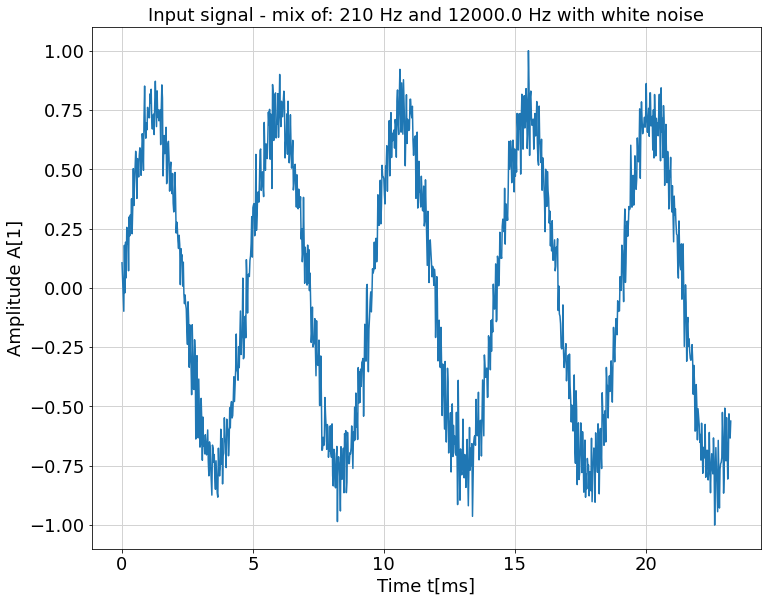

In [221]:
from sklearn.preprocessing import normalize

# Twice as many samples are needed
samples_count = 1024

# Testing frequencies
frequency_1 = 210 #30
frequency_2 = 12e3 #19999

np.random.seed(1)
noise = np.random.normal(loc=0, scale=0.1, size=samples_count)

sampling_time = samples_count * 1/sampling_frequency
print(f"Sampling time: {round(sampling_time*1000, 2)} ms of {samples_count} samples with {sampling_frequency} sps")

t = np.arange(samples_count)/sampling_frequency
val = np.sin(2*pi*frequency_1*t) + 0.1 * np.sin(2*pi*frequency_2*t) +noise
print(f"// Data generated using Jupyter Notebook. The signal mixes {frequency_1} Hz, {frequency_2} Hz and white noise.")

v_min = min(val)
v_max = max(val)
val = (val - v_min) / (v_max - v_min)
val = val * 2 - 1

print('Normalize results: ', min(val), max(val))
# val = [floor(4095 * v) for v in v_norm.astype('float32').tolist()]
# print('Normalize results 4096: ', min(val), max(val))

v_4096 = val.copy()
v_4096 = (v_4096 + 1) * (4096 - 1) / 2
v_4096 = v_4096.astype('int')
print('Normalize results: ', min(v_4096), max(v_4096))


plt.plot(t*1000, val)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.xlabel("Time t[ms]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title(f"Input signal - mix of: {frequency_1} Hz and {frequency_2} Hz with white noise", fontsize=18)
plt.show()


# FFT Evaluation
Fast Fourier Transformation allows converting time-base samples of the signal to frequency-based magnitudes. The magnitude depict the content of specific frequency in the signal. On the magnitude plot there are visible 2 lobes: on on the left side (low frequencies) one on the right side (higher frequencies).

Mags count: 512


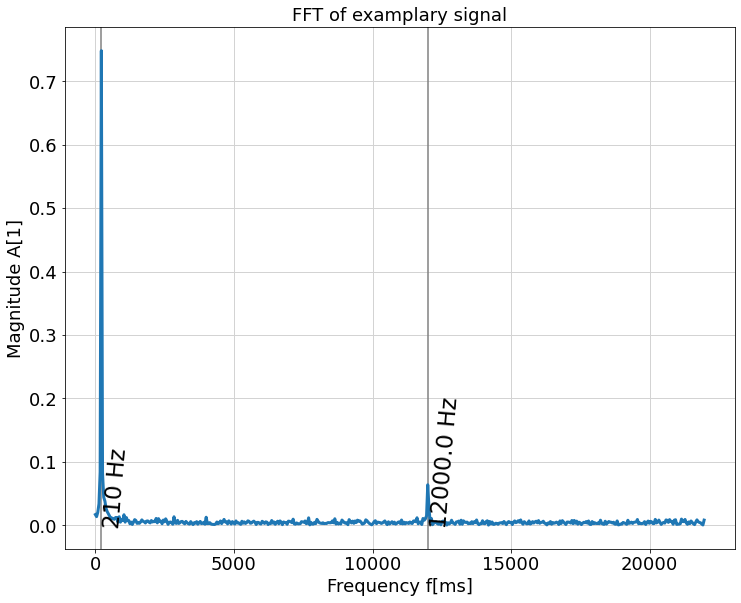

In [222]:
import scipy.fftpack


yf = scipy.fftpack.fft(val)
xf = sampling_frequency*np.arange(samples_count)/samples_count

freqs = xf[:samples_count//2]
mags = 2.0/samples_count * np.abs(yf[:samples_count//2])
print(f"Mags count: {len(mags)}")

sig_fft_real = yf.real
sig_fft_imag = yf.imag

plt.axvline(x=frequency_1, c="gray")
plt.axvline(x=frequency_2, c="gray")
plt.plot(freqs, mags, linewidth=3)
# plt.xscale("log")
# plt.yscale("log")
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.text(frequency_1, 1e-3, f"{frequency_1} Hz", fontsize = 23, rotation=85)
plt.text(frequency_2, 1e-3, f"{frequency_2} Hz", fontsize = 23, rotation=85)
plt.xlabel("Frequency f[ms]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal', fontsize=18)
plt.show()

# Bins and bands

In some cases all resulting FFT magnitude samples are not needed. They can be condensated using bands. Each bands represents specific frequency range in which corresponding frequency magnitudes are added.

To help evalueating this process **bins LUT** (Lookup table) is made.

Worth mentioning is that it is better to use exponential function to calculate bins indices. You can compare it by looking at FFT with or without logscale. Low frequencies are visualised more precisely than higher ones. In contrast, when using the linear function all bands will have the same band widths.


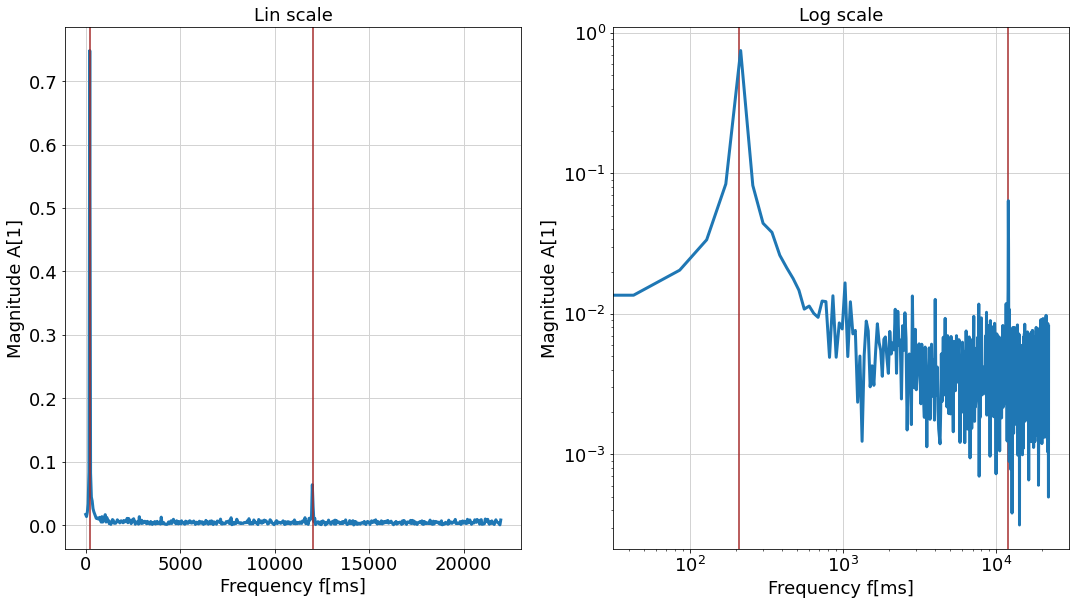

In [223]:
plt.rcParams['figure.figsize'] = [plots_scale*15*1.5, plots_scale*12]

plt.subplot(1, 2, 1)
plt.plot(freqs, mags, linewidth=3)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.axvline(x=frequency_1, c="brown")
plt.axvline(x=frequency_2, c="brown")
plt.xlabel("Frequency f[ms]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'Lin scale', fontsize=18)

plt.subplot(1, 2, 2)
plt.xscale("log")
plt.yscale("log")
plt.axvline(x=frequency_1, c="brown")
plt.axvline(x=frequency_2, c="brown")
plt.plot(freqs, mags, linewidth=3)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.xlabel("Frequency f[ms]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'Log scale', fontsize=18)

plt.show()

plt.rcParams['figure.figsize'] = [plots_scale*15, plots_scale*12]

# Bins function
Using exponential function with variable exponent the suitable convertion can be achieved.

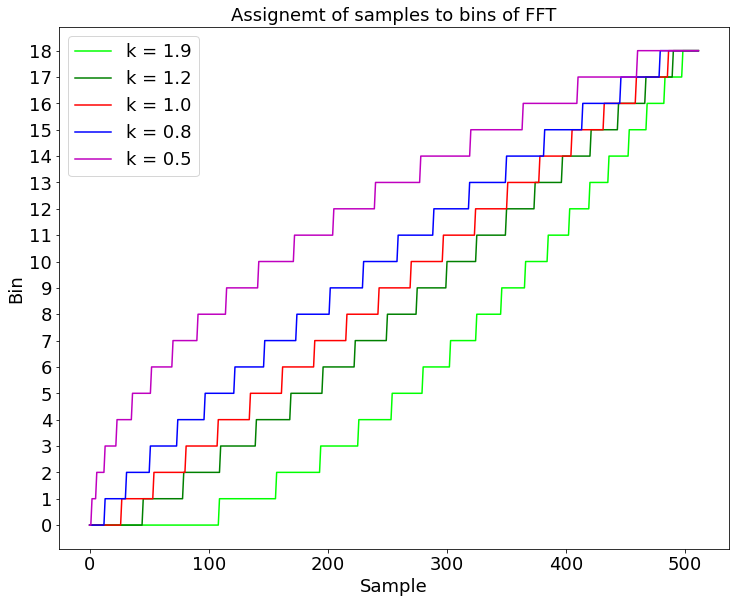

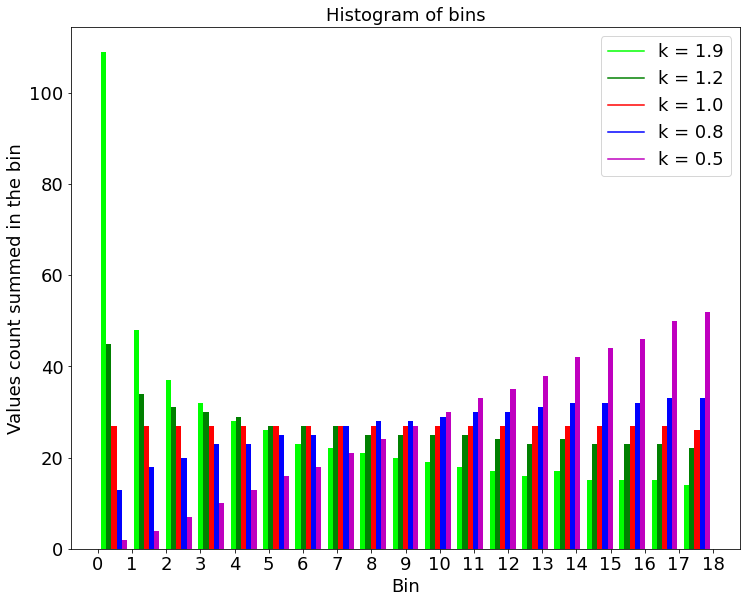

In [224]:
from collections import Counter
from math import floor

bands_count = 19

def gen_bins(bands_count, samples_count, k=1.0):
  return [floor(bands_count*(i/samples_count)**k) for i in range(0, samples_count)]


samples_idx = [i for i in range(0, samples_count // 2)]

k_factors = [1.9, 1.2, 1.0, 0.8, round(1/2, 2)]
plot_colors = ['lime', 'g', 'r', 'b', 'm']
plot_labels = [f"k = {k}" for k in k_factors]
bins_per_k = [gen_bins(bands_count, samples_count // 2, k) for k in k_factors]

plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

lines = [plt.plot(samples_idx, [str(bin) for bin in bins], plot_colors[idx])[0] for idx, bins in enumerate(bins_per_k)]
plt.title('Assignemt of samples to bins of FFT', fontsize=18)
plt.ylabel('Bin', fontsize=18)
plt.xlabel('Sample', fontsize=18);
plt.legend(lines, plot_labels, fontsize=18)
plt.show()

plt.hist([[str(bin) for bin in bins] for bins in bins_per_k], density=False, bins=bands_count, color=plot_colors, label=plot_labels)  # density=False would make counts
plt.title('Histogram of bins', fontsize=18)
plt.ylabel('Values count summed in the bin', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.legend(lines, plot_labels, fontsize=18)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.show()


# Band width
The **k** factor should be chosen so that the resulting function won't omit any bound. If value of k factor is too low it can happen that bands 0 or 1 won't have any assignment.

Number of bins per bound:  {0: 1, 1: 2, 2: 3, 3: 6, 4: 8, 5: 11, 6: 14, 7: 18, 8: 20, 9: 24, 10: 29, 11: 31, 12: 36, 13: 41, 14: 44, 15: 49, 16: 54, 17: 58, 18: 63} , total:  512 

Bin 0 from 0.0 Hz to 43.05 Hz, range: 43.05 Hz
Bin 1 from 43.05 Hz to 129.16 Hz, range: 86.11 Hz
Bin 2 from 129.16 Hz to 258.32 Hz, range: 129.16 Hz
Bin 3 from 258.32 Hz to 516.63 Hz, range: 258.32 Hz
Bin 4 from 516.63 Hz to 861.06 Hz, range: 344.42 Hz
Bin 5 from 861.06 Hz to 1334.64 Hz, range: 473.58 Hz
Bin 6 from 1334.64 Hz to 1937.38 Hz, range: 602.74 Hz
Bin 7 from 1937.38 Hz to 2712.33 Hz, range: 774.95 Hz
Bin 8 from 2712.33 Hz to 3573.39 Hz, range: 861.06 Hz
Bin 9 from 3573.39 Hz to 4606.65 Hz, range: 1033.27 Hz
Bin 10 from 4606.65 Hz to 5855.19 Hz, range: 1248.53 Hz
Bin 11 from 5855.19 Hz to 7189.82 Hz, range: 1334.64 Hz
Bin 12 from 7189.82 Hz to 8739.73 Hz, range: 1549.9 Hz
Bin 13 from 8739.73 Hz to 10504.89 Hz, range: 1765.17 Hz
Bin 14 from 10504.89 Hz to 12399.22 Hz, range: 1894.32 Hz
Bin 15 from 12

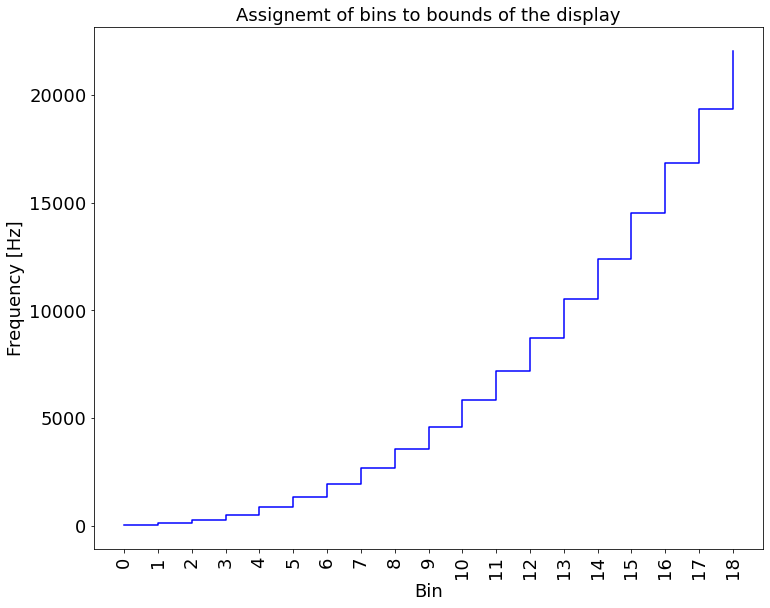

In [225]:
bins_assignment_k = 0.41 #0.45
bins = gen_bins(bands_count, samples_count // 2, bins_assignment_k)

resolution_width = sampling_frequency/2 / (samples_count // 2-1)
# print(f"Single resoolution width: {round(bin_width, 3)} Hz\n")

bins_count = dict(Counter(bins))
print("Number of bins per bound: ", bins_count, ", total: ", sum(bins_count.values()) , "\n")

plt.xticks(fontsize= 18, rotation=90)
plt.yticks(fontsize= 18)

ranges = [0]*bands_count

for idx in range(bands_count):
  band_width = bins_count[idx] * resolution_width
  ranges[idx] = ranges[idx - 1] + band_width if idx > 0 else band_width
  print(f"Bin {idx} from {round(ranges[idx] - band_width, 2)} Hz to {round(ranges[idx],2)} Hz, range: {round(band_width, 2)} Hz")

# plt.plot([str(bin) for bin in bins], samples_idx, 'r')
plt.step([str(bin) for bin in set(bins)], ranges, 'b', where='post')
plt.title('Assignemt of bins to bounds of the display', fontsize=18)
plt.ylabel('Frequency [Hz]', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()




# Audio Spectrum Display Visualization
Resulting values of the bandsare scaled to fit height of the display. In the target system there will be gaincontrol of the audio input signal. In software ther is clipping function so that the height won't exceed the display's dimensions.

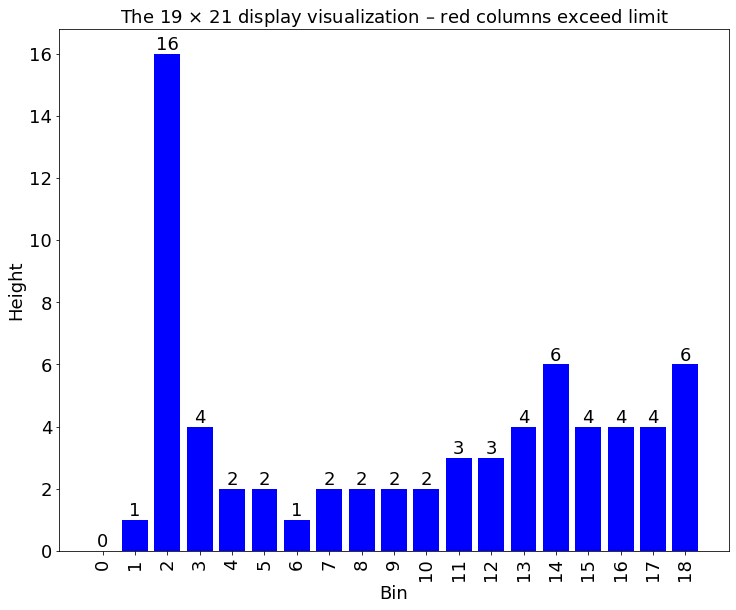

In [226]:
columns_values = [0]*bands_count
display_gain = 19
display_height = 21

for idx, mag in enumerate(mags):
  columns_values[bins[idx]] += mag

heights = [cv*display_gain for cv in columns_values]

colors = ['blue' if height_v < display_height else 'red' for height_v in heights]
heights = [round(min(height_v, display_height)) for height_v in heights]

bars = plt.bar([str(i) for i in range(bands_count)], heights, color=colors)

for rect in bars:
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom', fontsize=18)

plt.xticks(fontsize= 18, rotation=90)
plt.yticks(fontsize= 18)
plt.title(f"The {bands_count} " + r"$\times$" + f" {display_height} display visualization – red columns exceed limit", fontsize=18)
plt.ylabel('Height', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()



## Output bins

In [227]:
variable_name_bins_count = "BINS_COUNT"
print(f"#define {variable_name_bins_count} {len(bins)}")
print(f"const int bins[{variable_name_bins_count}] = " + "{" + str(bins)[1:-1] + "};\n")

#define BINS_COUNT 512
const int bins[BINS_COUNT] = {0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14

# Comparison datas

Time-based and frequency-based datas. Copy-paste to embedded system project.

In [228]:
variable_name_test_samples_count = "TEST_SAMPLES_COUNT"
print(f"// Data generated using Jupyter Notebook. The signal mixes {frequency_1} Hz, {frequency_2} Hz and white noise.")
print(f"#define {variable_name_test_samples_count} {len(val)}")

print(f"const float32_t test_signal[{variable_name_test_samples_count}] = " + "{" + str([round(v, 4) for v in val.astype('float32').tolist()])[1:-1] + "};\n")

// Data generated using Jupyter Notebook. The signal mixes 210 Hz, 12000.0 Hz and white noise.
#define TEST_SAMPLES_COUNT 1024
const float32_t test_signal[TEST_SAMPLES_COUNT] = {0.1057, 0.0343, -0.0327, -0.0986, 0.1795, -0.0208, 0.1928, 0.0422, 0.2551, 0.1868, 0.2417, 0.0721, 0.2992, 0.2197, 0.3076, 0.269, 0.3755, 0.2281, 0.3333, 0.5028, 0.3472, 0.4392, 0.5136, 0.5759, 0.5272, 0.3771, 0.5451, 0.5159, 0.4676, 0.5589, 0.5905, 0.5791, 0.4745, 0.55, 0.65, 0.6153, 0.4955, 0.7173, 0.8508, 0.6767, 0.631, 0.6958, 0.6663, 0.761, 0.7178, 0.7459, 0.717, 0.8177, 0.781, 0.8374, 0.7014, 0.6696, 0.72, 0.7324, 0.6463, 0.7796, 0.8712, 0.7794, 0.6799, 0.8304, 0.7182, 0.7501, 0.7044, 0.7459, 0.7504, 0.6039, 0.761, 0.8557, 0.8, 0.4719, 0.5666, 0.642, 0.5659, 0.6233, 0.677, 0.4393, 0.4584, 0.6037, 0.6178, 0.546, 0.4079, 0.5021, 0.5302, 0.4152, 0.3973, 0.4822, 0.3563, 0.3201, 0.3558, 0.4866, 0.3756, 0.2311, 0.2774, 0.2526, 0.1974, 0.1659, 0.2218, 0.1817, 0.0136, 0.1655, 0.1315, 0.1392, 0.0074, 0.1086, -0.02

In [229]:

print(f"const uint16_t ADC_SAMPLES[{'1024*2'}] = " + "{" + str([vv for vv in v_4096.tolist()])[1:-1] + "};\n")

const uint16_t ADC_SAMPLES[1024*2] = {2263, 2117, 1980, 1845, 2415, 2004, 2442, 2133, 2569, 2429, 2542, 2195, 2660, 2497, 2677, 2598, 2816, 2514, 2729, 3076, 2758, 2946, 3099, 3226, 3126, 2819, 3163, 3103, 3004, 3191, 3256, 3233, 3019, 3173, 3378, 3307, 3062, 3516, 3789, 3433, 3339, 3472, 3411, 3605, 3517, 3574, 3515, 3721, 3646, 3762, 3483, 3418, 3521, 3547, 3370, 3643, 3831, 3643, 3439, 3747, 3517, 3583, 3489, 3574, 3584, 3283, 3605, 3799, 3685, 3013, 3207, 3362, 3206, 3323, 3433, 2947, 2986, 3283, 3312, 3165, 2882, 3075, 3133, 2897, 2861, 3034, 2776, 2702, 2776, 3043, 2816, 2520, 2615, 2564, 2451, 2387, 2501, 2419, 2075, 2386, 2316, 2332, 2062, 2269, 1995, 1911, 1986, 1902, 1865, 1669, 1559, 1927, 1767, 1361, 1728, 1460, 1379, 1125, 1729, 1479, 1174, 1170, 1599, 1469, 742, 1406, 1462, 992, 752, 1260, 967, 672, 696, 1093, 904, 559, 932, 681, 722, 614, 779, 673, 606, 720, 821, 547, 425, 718, 678, 502, 372, 258, 690, 665, 543, 608, 404, 309, 554, 413, 277, 240, 663, 489, 424, 483, 827,

In [230]:
out_mags = np.abs(sig_fft_real + 1j*sig_fft_imag)
assert(len(out_mags) == len(val))
print(f"// Len of mags = {len(out_mags)} should be equal to len of time samples = {len(val)}. Use half.")
print(f"const float32_t test_megs[{variable_name_test_samples_count}] = " + "{" + str([round(mg, 4) for mg in out_mags.astype('float32').tolist()])[1:-1] + "};\n")

// Len of mags = 1024 should be equal to len of time samples = 1024. Use half.
const float32_t test_megs[TEST_SAMPLES_COUNT] = {8.6491, 6.9519, 10.4759, 17.2437, 43.0361, 383.0974, 42.0149, 22.6007, 19.4806, 13.3805, 10.8686, 9.13, 7.5387, 5.5343, 5.82, 5.1577, 4.8365, 6.3182, 6.2587, 2.51, 6.8874, 2.5146, 4.4137, 3.9995, 8.5074, 2.5425, 6.2424, 3.6889, 3.9016, 1.2035, 2.5644, 0.6343, 2.6139, 4.5499, 3.8666, 1.5483, 2.1858, 1.5869, 2.7868, 4.3528, 3.2132, 2.8158, 1.8404, 3.3764, 3.5081, 2.4857, 1.9314, 3.8398, 2.6498, 3.1805, 2.838, 5.5193, 1.9342, 5.3441, 3.0662, 3.3337, 1.2695, 4.2164, 2.8156, 5.2104, 3.4164, 0.7632, 2.3257, 2.6532, 1.9351, 0.8339, 6.8643, 1.9359, 1.5235, 3.9756, 1.4753, 2.0398, 3.0361, 3.1326, 1.8339, 1.1726, 3.1136, 2.0849, 1.2733, 0.9383, 2.9713, 1.843, 0.5796, 2.1126, 1.6894, 2.9317, 0.9095, 1.862, 3.1153, 1.3274, 1.6002, 2.406, 0.8975, 6.4893, 1.3419, 1.407, 2.1406, 1.0526, 0.7748, 0.6904, 0.6086, 1.0401, 2.6559, 1.2163, 1.8425, 3.4893, 1.3544, 2.8792, 4.757, 2.

# IFFT check - frequency domain

The comparison of FFT evaluated using scipy and evaluated on embedded system.

Copy-paste 512 magnitudes, 1024 imaginary values and 1024 real parts. In CMSIS library input array is twice as long (2048) because of complex number representation. Resulting magnitudes buffer is 1024 long, but only half of it is used - 512 samples in total, representing frequencies from 0 to helf of sampling frequency (0-22kHz).

Time samples count: (1024,)
FFT output samples, real part count: (1024,)
FFT output samples, imaginary part count: (1024,)
To check rersults fill the arrays (of length 1024) from output of embedded system.
1024


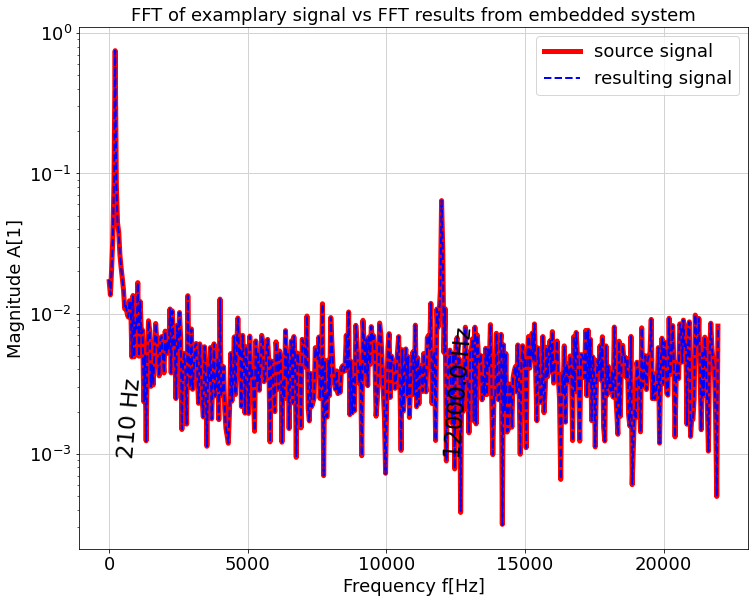

In [231]:
print(f"Time samples count: {t.shape}")
xf = sampling_frequency*np.arange(samples_count//2)/samples_count

print(f"FFT output samples, real part count: {sig_fft_real.shape}")
print(f"FFT output samples, imaginary part count: {sig_fft_imag.shape}")
sig_fft = sig_fft_real + 1j*sig_fft_imag
source_mags = 2.0/samples_count * np.abs(sig_fft_real + 1j*sig_fft_imag)[:samples_count//2]

print(f"To check rersults fill the arrays (of length {len(t)}) from output of embedded system.")

# Fill those arrays with readings, full length equal 'samples_count'
res_fft_real = np.array([-8.893, 6.500, 7.046, 6.170, 16.888, -129.514, -12.556, -4.873, -7.328, -3.493, -1.417, -0.140, -0.148, -1.226, 0.546, -1.925, 0.966, -1.938, 0.006, 0.362, -0.444, -1.652, 0.097, 0.929, 0.202, -2.169, -0.743, 2.183, 1.677, -0.063, -1.757, 0.024, -1.562, 1.860, -1.380, 1.450, 1.400, -1.405, 0.845, -4.213, -3.170, 1.671, 1.017, -0.755, 1.221, -2.025, 0.156, 0.008, 1.649, 1.898, 2.702, -2.900, 0.962, 2.059, -2.566, 0.666, -1.267, 0.257, -2.409, 2.431, 1.298, 0.675, 0.935, 0.703, -1.896, -0.660, 2.781, 1.203, -1.177, 1.126, -1.416, -1.125, 2.485, 0.075, 1.597, 0.912, -0.981, 2.071, -0.749, 0.898, 2.946, -1.428, 0.528, -0.459, 1.676, -0.479, -0.107, 0.881, 0.200, 0.779, 1.214, 2.063, 0.598, 2.854, 0.758, -1.182, -0.590, 0.712, 0.764, 0.311, -0.151, -0.338, 2.085, -1.196, -1.718, 2.636, 0.006, 2.820, 1.260, 0.946, 1.902, -0.257, 3.575, 0.386, 0.619, -1.809, -1.029, -0.547, -0.078, -1.043, 1.724, -0.474, 0.056, 3.015, 0.567, -1.671, 1.307, 1.655, 3.505, 3.149, -1.672, 1.770, 1.393, 1.778, 0.031, -0.605, 1.780, 2.303, 0.886, -1.011, 3.218, 1.567, 0.779, 1.759, -0.641, 0.358, -1.450, 0.849, -2.893, -1.740, 1.836, 0.699, 1.563, -3.216, 1.072, -1.349, -0.441, -0.023, -2.143, 2.130, -2.081, 0.154, 3.198, -1.308, -1.977, 0.741, 3.081, -0.579, -0.650, -1.131, 0.255, 1.174, 1.267, -1.214, -1.155, 0.317, -2.566, -0.389, 0.079, -4.570, -0.229, 2.124, 0.535, -0.399, 1.720, 0.515, 2.711, 0.621, 0.103, 0.327, -1.351, 1.846, 0.936, -1.188, -1.034, 1.931, 2.171, 0.309, -0.435, 3.130, -0.406, 4.300, 0.624, 0.184, -0.881, -1.566, -0.148, 1.200, 3.107, -0.516, 1.494, 1.546, 0.002, 4.163, 1.928, -0.099, 0.875, 1.482, -1.962, 1.385, -4.131, 3.162, -0.922, 0.085, 0.795, -0.588, 1.177, 2.197, 3.571, 1.547, -1.065, 0.318, -0.293, -0.348, 0.177, 1.566, -0.793, -0.848, 2.196, 2.004, 0.311, 1.789, 1.385, 3.120, 0.678, 0.497, 2.022, 0.027, -1.386, -2.819, 1.260, 2.061, 0.707, 1.293, -1.728, -1.912, 0.999, -4.232, -0.959, 2.241, -1.120, 1.417, 0.024, 0.727, 1.100, -1.644, -1.232, 3.008, 3.151, 1.668, 4.720, 1.141, -1.661, 1.607, 0.259, 5.481, 0.998, 4.215, 4.679, 25.924, -10.164, -2.117, -2.193, 0.359, -0.309, 0.183, 2.029, -1.350, 0.147, -2.437, -0.024, 2.812, 2.688, -1.242, 2.295, -0.193, -2.056, -0.982, 0.823, -0.712, -0.747, -0.890, -0.001, 2.691, 2.823, -3.013, 0.538, 1.845, -0.275, 3.058, 0.183, 0.602, -2.305, 0.205, -0.787, 0.821, 1.229, -1.204, 1.237, 2.069, -4.103, 0.142, -0.416, 0.608, -0.808, -0.915, 1.123, -1.224, 2.989, 2.577, -0.021, 3.067, -0.403, 2.649, 0.689, -0.650, 0.412, -1.184, -0.468, -0.333, -1.987, -0.914, -0.847, 1.007, -0.634, 0.441, -0.489, 1.205, 0.768, 1.826, -0.538, 2.518, 2.471, 1.244, -2.040, -0.489, -1.568, -1.448, -0.303, 0.846, -1.373, 0.157, 0.392, -1.028, 0.208, 0.082, 0.849, -1.539, 1.125, -2.079, -0.488, -1.596, 3.381, 0.807, -1.383, 2.203, 1.834, 1.092, 1.177, -0.328, -1.562, 0.372, 2.579, -0.021, 2.095, -0.763, 1.913, -1.722, 1.912, -0.621, 2.823, 0.761, 3.719, -2.486, -1.198, 0.602, -0.713, 2.261, -2.413, -1.360, 1.548, -0.015, -3.788, -0.446, -0.144, 0.628, 2.458, -1.406, -0.570, -1.652, -1.733, -1.970, -2.627, 1.714, 3.430, 0.723, -0.116, 2.852, -0.025, -0.121, -1.160, 0.283, -0.141, 1.012, 3.819, -1.159, -1.022, -0.166, -0.327, -0.476, 1.818, -1.954, 1.703, 2.509, 0.736, 0.048, 0.968, 0.702, 0.212, -0.299, -0.535, 0.358, -0.592, -1.294, 1.872, -0.270, -0.031, -4.050, -1.349, 1.355, -0.406, -0.835, -0.746, 2.559, 1.766, -4.229, 0.318, -1.884, 1.104, 1.305, 1.238, -2.415, 0.326, -0.015, -1.566, -1.504, 1.089, 1.926, -0.581, 1.339, 3.431, -1.889, -2.357, 0.528, 0.955, -0.615, 1.668, 1.303, -1.359, 3.709, -2.035, -0.807, 0.983, -2.400, 3.161, 0.830, 1.739, 1.169, 0.582, -0.192, -0.757, -0.974, 2.085, 2.661, -0.803, 2.957, 0.335, -0.657, 1.392, 1.224, 3.473, 2.200, 0.197, 0.221, 2.535, 1.281, 1.577, 0.179, 1.968, -0.500, 0.095, 4.118, 0.986, 4.118, 0.095, -0.500, 1.968, 0.179, 1.577, 1.281, 2.535, 0.221, 0.197, 2.200, 3.473, 1.224, 1.392, -0.657, 0.335, 2.957, -0.803, 2.661, 2.085, -0.974, -0.757, -0.192, 0.582, 1.169, 1.739, 0.830, 3.161, -2.400, 0.983, -0.807, -2.035, 3.709, -1.359, 1.303, 1.668, -0.615, 0.955, 0.528, -2.357, -1.889, 3.431, 1.339, -0.581, 1.926, 1.089, -1.504, -1.566, -0.015, 0.326, -2.415, 1.238, 1.305, 1.104, -1.884, 0.318, -4.229, 1.766, 2.559, -0.746, -0.835, -0.406, 1.355, -1.349, -4.050, -0.031, -0.270, 1.872, -1.294, -0.592, 0.358, -0.535, -0.299, 0.212, 0.702, 0.968, 0.048, 0.736, 2.509, 1.703, -1.954, 1.818, -0.476, -0.327, -0.166, -1.022, -1.159, 3.819, 1.012, -0.141, 0.283, -1.160, -0.121, -0.025, 2.852, -0.116, 0.723, 3.430, 1.714, -2.627, -1.970, -1.733, -1.652, -0.570, -1.406, 2.458, 0.628, -0.144, -0.446, -3.788, -0.015, 1.548, -1.360, -2.413, 2.261, -0.713, 0.602, -1.198, -2.486, 3.719, 0.761, 2.823, -0.621, 1.912, -1.722, 1.913, -0.763, 2.095, -0.021, 2.579, 0.372, -1.562, -0.328, 1.177, 1.092, 1.834, 2.203, -1.383, 0.807, 3.381, -1.596, -0.488, -2.079, 1.125, -1.539, 0.849, 0.082, 0.208, -1.028, 0.392, 0.157, -1.373, 0.846, -0.303, -1.448, -1.568, -0.489, -2.040, 1.244, 2.471, 2.518, -0.538, 1.826, 0.768, 1.205, -0.489, 0.441, -0.634, 1.007, -0.847, -0.914, -1.987, -0.333, -0.468, -1.184, 0.412, -0.650, 0.689, 2.649, -0.403, 3.067, -0.021, 2.577, 2.989, -1.224, 1.123, -0.915, -0.808, 0.608, -0.416, 0.142, -4.103, 2.069, 1.237, -1.204, 1.229, 0.821, -0.787, 0.205, -2.305, 0.602, 0.183, 3.058, -0.275, 1.845, 0.538, -3.013, 2.823, 2.691, -0.001, -0.890, -0.747, -0.712, 0.823, -0.982, -2.056, -0.193, 2.295, -1.242, 2.688, 2.812, -0.024, -2.437, 0.147, -1.350, 2.029, 0.183, -0.309, 0.359, -2.193, -2.117, -10.164, 25.924, 4.679, 4.215, 0.998, 5.481, 0.259, 1.607, -1.661, 1.141, 4.720, 1.668, 3.151, 3.008, -1.232, -1.644, 1.101, 0.727, 0.024, 1.417, -1.120, 2.241, -0.959, -4.232, 0.999, -1.912, -1.728, 1.293, 0.707, 2.061, 1.260, -2.819, -1.386, 0.027, 2.022, 0.497, 0.678, 3.120, 1.385, 1.789, 0.311, 2.004, 2.196, -0.848, -0.793, 1.566, 0.177, -0.348, -0.293, 0.318, -1.065, 1.547, 3.571, 2.197, 1.177, -0.588, 0.795, 0.085, -0.922, 3.162, -4.131, 1.385, -1.962, 1.482, 0.875, -0.099, 1.928, 4.163, 0.002, 1.546, 1.495, -0.516, 3.107, 1.200, -0.148, -1.566, -0.881, 0.184, 0.624, 4.300, -0.406, 3.130, -0.435, 0.309, 2.171, 1.931, -1.034, -1.188, 0.936, 1.846, -1.351, 0.327, 0.103, 0.621, 2.711, 0.515, 1.720, -0.399, 0.535, 2.124, -0.229, -4.570, 0.079, -0.389, -2.566, 0.317, -1.155, -1.214, 1.267, 1.174, 0.255, -1.131, -0.650, -0.579, 3.081, 0.741, -1.977, -1.308, 3.198, 0.154, -2.081, 2.130, -2.143, -0.023, -0.441, -1.349, 1.072, -3.216, 1.563, 0.699, 1.836, -1.740, -2.893, 0.849, -1.450, 0.358, -0.641, 1.759, 0.779, 1.567, 3.218, -1.011, 0.886, 2.303, 1.780, -0.605, 0.031, 1.778, 1.393, 1.770, -1.672, 3.149, 3.505, 1.655, 1.307, -1.671, 0.567, 3.015, 0.056, -0.474, 1.724, -1.043, -0.078, -0.547, -1.029, -1.809, 0.619, 0.386, 3.575, -0.257, 1.902, 0.946, 1.260, 2.820, 0.006, 2.636, -1.718, -1.196, 2.085, -0.338, -0.151, 0.311, 0.764, 0.712, -0.590, -1.182, 0.758, 2.854, 0.598, 2.063, 1.214, 0.779, 0.200, 0.881, -0.107, -0.479, 1.676, -0.459, 0.528, -1.428, 2.946, 0.898, -0.749, 2.071, -0.981, 0.912, 1.597, 0.075, 2.485, -1.125, -1.416, 1.126, -1.177, 1.203, 2.781, -0.660, -1.896, 0.703, 0.935, 0.675, 1.298, 2.431, -2.409, 0.257, -1.267, 0.666, -2.566, 2.059, 0.962, -2.900, 2.702, 1.898, 1.649, 0.008, 0.156, -2.025, 1.221, -0.755, 1.017, 1.671, -3.170, -4.213, 0.845, -1.405, 1.400, 1.450, -1.380, 1.860, -1.562, 0.024, -1.757, -0.063, 1.677, 2.183, -0.743, -2.169, 0.202, 0.929, 0.097, -1.652, -0.444, 0.362, 0.006, -1.938, 0.966, -1.925, 0.546, -1.226, -0.148, -0.140, -1.417, -3.493, -7.328, -4.873, -12.556, -129.514, 16.888, 6.170, 7.046, 6.500])

res_fft_imag = np.array([0.000, 2.470, 7.747, 16.105, 39.588, -360.543, -40.090, -22.077, -18.051, -12.913, -10.771, -9.125, -7.536, -5.402, -5.793, -4.787, -4.734, -6.017, -6.255, -2.479, -6.875, -1.896, -4.412, -3.892, -8.501, -1.325, -6.198, -2.976, -3.527, -1.203, -1.879, 0.630, -2.101, -4.149, -3.613, -0.549, -1.683, -0.745, -2.652, -1.105, -0.533, -2.268, -1.537, -3.289, -3.291, -1.441, 1.927, -3.839, -2.071, -2.552, -0.851, -4.688, -1.677, -4.929, -1.673, -3.261, -0.030, -4.209, -1.454, -4.613, -3.161, -0.363, -2.124, -2.556, 0.389, 0.518, -6.275, 1.516, -0.971, -3.811, 0.424, -1.696, -1.735, -3.131, 0.910, 0.745, -2.958, -0.223, 1.029, -0.266, 0.413, -1.165, 0.243, -2.062, 0.232, -2.888, 0.902, 1.641, -3.106, -1.068, -1.037, 1.229, 0.672, -5.828, -1.114, -0.768, -2.058, -0.784, 0.098, 0.615, 0.594, 0.980, -1.647, 0.230, 0.670, -2.282, 1.354, -0.589, -4.592, -2.451, 2.079, -1.079, -0.146, -2.473, -0.783, -2.363, 1.593, -0.831, -3.528, 1.489, -1.162, -1.362, 0.743, 1.231, 1.586, -2.170, -0.636, 1.360, -0.732, -0.439, 0.100, -0.047, 2.421, -2.838, 2.302, 0.144, 1.539, 0.236, -0.963, -0.166, -0.047, -1.966, -1.262, 2.139, 2.415, -0.506, 0.851, 0.943, -2.567, -0.318, -1.905, -0.327, 1.512, 0.628, 0.496, -3.245, -2.441, 0.485, -1.591, -0.658, -0.507, -0.766, 0.997, -2.896, 1.978, -1.985, 3.831, -0.912, -0.586, -1.555, -1.078, -0.168, 0.148, -2.651, -2.419, -2.406, -2.353, 1.204, -1.662, 3.906, -0.277, -1.043, -0.779, -0.849, -1.653, -1.236, -3.953, -3.114, -2.022, -1.654, 0.578, 0.750, -1.005, -0.937, -0.949, -0.838, 0.123, -1.952, -2.090, -1.756, -1.975, 3.030, -0.744, -2.325, 0.472, 0.813, 1.025, 4.050, 0.715, -2.061, 0.668, 1.498, 0.497, 1.911, 2.473, -1.874, -3.239, 0.483, 2.876, -1.732, -0.235, -0.688, -3.427, -2.580, -0.512, -1.075, 1.493, -3.797, 0.944, -1.895, 1.020, 0.893, -0.222, 1.248, -2.933, 3.333, -1.018, -2.393, -0.685, -0.776, -1.467, 0.352, -2.367, -1.601, -1.504, -0.207, -1.975, -1.034, 1.437, -0.538, -0.464, -1.444, -0.608, 0.772, 1.763, -1.945, 0.913, -0.152, 0.556, -1.050, 0.304, -1.663, -1.945, -1.233, -2.416, -0.584, -0.697, -1.663, -1.700, -2.324, -3.795, -0.275, 1.839, -2.136, -0.580, 0.609, -3.952, -2.968, -5.987, -19.907, 10.697, 1.664, 5.092, 0.279, 1.614, 2.301, 1.946, 0.025, -0.831, 1.014, -0.400, 1.012, 2.164, 1.820, -0.773, -0.053, -0.061, -0.287, 1.766, 4.036, 1.737, -1.363, -0.722, 0.289, -0.294, -1.542, -0.702, 3.656, 0.793, 1.900, -2.523, 2.218, -1.139, 1.228, -1.626, 1.065, 2.617, 0.625, 2.562, -0.365, -1.195, 1.372, 0.287, -1.150, -0.986, -3.591, 0.884, 0.176, 0.277, -2.571, 0.158, 0.074, 0.970, -0.110, -0.265, -0.399, -1.560, -0.953, 0.636, -1.745, -0.023, -1.945, 1.134, -2.889, -1.602, -0.247, 2.253, 2.768, -1.993, -1.597, -0.175, -0.378, -2.509, -1.677, 1.556, 3.678, -1.816, -4.076, 1.951, 0.238, -2.572, -2.010, 1.123, -0.733, -3.506, -1.002, 1.218, 2.511, -1.423, -1.825, -3.247, 1.140, -1.770, -1.419, 1.733, 1.153, 2.701, -1.436, -0.445, 0.083, -1.076, -1.337, 1.559, 0.857, -0.790, 1.485, 0.041, -1.894, -0.385, -0.137, -2.083, 1.194, -0.522, -0.954, 0.994, 0.175, 2.512, -1.277, 0.205, -1.148, 3.571, -1.335, 0.895, -1.610, -3.344, -0.625, -0.514, 1.336, -0.079, 0.216, -1.625, -0.471, -1.467, -0.059, -0.676, -0.329, 0.620, 0.972, -1.341, 2.152, 0.965, -1.413, 1.943, 0.811, 1.492, 0.954, 0.122, -0.688, 3.234, -0.818, -1.046, 2.330, 1.762, -0.088, -1.645, 2.453, 0.062, 0.398, -3.511, 0.086, 0.174, 0.981, 0.720, -1.912, 0.152, 1.454, 0.738, -0.113, -0.756, -1.252, 2.530, -1.211, -2.279, -0.020, 2.051, -1.934, 1.225, -0.290, -0.613, 0.461, -1.106, -1.651, -0.516, 2.294, 3.038, 0.598, -3.015, 1.962, 1.258, -0.094, -3.271, -0.113, -0.884, 4.170, 2.033, 0.282, 0.730, -1.869, 1.118, 2.216, 3.495, -2.162, 4.494, -1.809, 0.197, 0.062, -3.761, 4.319, 0.355, -0.886, 0.479, -0.777, 4.539, -1.442, 2.863, 3.688, -1.845, 0.377, 2.294, -0.547, 0.220, -0.784, 1.173, -0.486, 0.682, 4.178, -2.443, -2.287, -0.608, -0.848, -0.236, -0.670, 0.000, 0.670, 0.236, 0.848, 0.608, 2.287, 2.443, -4.178, -0.682, 0.486, -1.173, 0.784, -0.220, 0.547, -2.294, -0.377, 1.845, -3.688, -2.863, 1.442, -4.539, 0.777, -0.479, 0.886, -0.355, -4.319, 3.761, -0.062, -0.197, 1.809, -4.494, 2.162, -3.495, -2.216, -1.118, 1.869, -0.730, -0.282, -2.033, -4.170, 0.884, 0.113, 3.271, 0.094, -1.258, -1.962, 3.015, -0.598, -3.038, -2.294, 0.516, 1.651, 1.106, -0.461, 0.613, 0.290, -1.225, 1.934, -2.051, 0.020, 2.279, 1.211, -2.530, 1.252, 0.756, 0.113, -0.738, -1.454, -0.152, 1.912, -0.720, -0.981, -0.174, -0.086, 3.511, -0.398, -0.062, -2.453, 1.645, 0.088, -1.762, -2.330, 1.046, 0.818, -3.234, 0.688, -0.122, -0.954, -1.492, -0.811, -1.943, 1.413, -0.965, -2.152, 1.341, -0.972, -0.620, 0.329, 0.676, 0.059, 1.467, 0.471, 1.625, -0.216, 0.079, -1.336, 0.514, 0.625, 3.344, 1.610, -0.895, 1.335, -3.571, 1.148, -0.205, 1.277, -2.512, -0.175, -0.994, 0.954, 0.522, -1.194, 2.083, 0.137, 0.385, 1.894, -0.041, -1.485, 0.790, -0.857, -1.559, 1.337, 1.076, -0.083, 0.445, 1.436, -2.701, -1.153, -1.733, 1.419, 1.770, -1.140, 3.247, 1.825, 1.423, -2.511, -1.218, 1.002, 3.506, 0.733, -1.123, 2.010, 2.572, -0.238, -1.951, 4.076, 1.816, -3.678, -1.556, 1.677, 2.509, 0.378, 0.175, 1.597, 1.993, -2.768, -2.253, 0.247, 1.602, 2.889, -1.134, 1.945, 0.023, 1.745, -0.636, 0.953, 1.560, 0.399, 0.265, 0.110, -0.970, -0.074, -0.158, 2.571, -0.277, -0.176, -0.884, 3.591, 0.986, 1.150, -0.287, -1.372, 1.195, 0.365, -2.562, -0.625, -2.617, -1.065, 1.626, -1.228, 1.139, -2.218, 2.523, -1.900, -0.793, -3.656, 0.702, 1.542, 0.294, -0.289, 0.722, 1.363, -1.737, -4.036, -1.766, 0.287, 0.061, 0.053, 0.773, -1.820, -2.164, -1.012, 0.400, -1.014, 0.831, -0.025, -1.946, -2.301, -1.614, -0.279, -5.092, -1.664, -10.697, 19.907, 5.987, 2.968, 3.952, -0.609, 0.580, 2.136, -1.839, 0.275, 3.795, 2.324, 1.700, 1.663, 0.697, 0.584, 2.416, 1.233, 1.945, 1.663, -0.304, 1.050, -0.556, 0.152, -0.913, 1.945, -1.763, -0.772, 0.608, 1.444, 0.464, 0.538, -1.437, 1.034, 1.975, 0.207, 1.504, 1.601, 2.367, -0.352, 1.467, 0.776, 0.685, 2.393, 1.018, -3.333, 2.933, -1.248, 0.222, -0.893, -1.020, 1.895, -0.944, 3.797, -1.493, 1.075, 0.512, 2.580, 3.427, 0.688, 0.235, 1.732, -2.876, -0.483, 3.239, 1.874, -2.473, -1.911, -0.497, -1.498, -0.668, 2.061, -0.715, -4.050, -1.025, -0.813, -0.472, 2.325, 0.744, -3.030, 1.975, 1.756, 2.090, 1.952, -0.123, 0.838, 0.949, 0.937, 1.005, -0.750, -0.578, 1.654, 2.022, 3.114, 3.953, 1.236, 1.653, 0.849, 0.779, 1.043, 0.277, -3.906, 1.662, -1.204, 2.353, 2.406, 2.419, 2.651, -0.148, 0.168, 1.078, 1.555, 0.586, 0.912, -3.831, 1.985, -1.978, 2.896, -0.997, 0.766, 0.507, 0.658, 1.591, -0.485, 2.441, 3.245, -0.496, -0.628, -1.512, 0.327, 1.905, 0.318, 2.567, -0.943, -0.851, 0.506, -2.415, -2.139, 1.262, 1.966, 0.047, 0.166, 0.963, -0.236, -1.539, -0.144, -2.302, 2.838, -2.421, 0.047, -0.100, 0.439, 0.732, -1.360, 0.636, 2.170, -1.586, -1.231, -0.743, 1.362, 1.162, -1.489, 3.528, 0.831, -1.593, 2.363, 0.783, 2.473, 0.146, 1.079, -2.079, 2.451, 4.592, 0.589, -1.354, 2.282, -0.670, -0.230, 1.647, -0.980, -0.594, -0.615, -0.098, 0.784, 2.058, 0.768, 1.114, 5.828, -0.672, -1.229, 1.037, 1.068, 3.106, -1.641, -0.902, 2.888, -0.232, 2.062, -0.243, 1.165, -0.413, 0.266, -1.029, 0.223, 2.958, -0.745, -0.910, 3.131, 1.735, 1.696, -0.424, 3.811, 0.971, -1.516, 6.275, -0.518, -0.389, 2.556, 2.124, 0.363, 3.161, 4.613, 1.454, 4.209, 0.030, 3.261, 1.673, 4.929, 1.677, 4.688, 0.851, 2.552, 2.071, 3.839, -1.927, 1.441, 3.291, 3.289, 1.537, 2.268, 0.533, 1.105, 2.652, 0.745, 1.683, 0.549, 3.613, 4.149, 2.101, -0.630, 1.879, 1.203, 3.527, 2.976, 6.198, 1.325, 8.501, 3.892, 4.412, 1.896, 6.875, 2.479, 6.255, 6.017, 4.734, 4.787, 5.793, 5.402, 7.536, 9.125, 10.771, 12.913, 18.051, 22.077, 40.090, 360.543, -39.588, -16.105, -7.747, -2.470])

resulting_mags = 2.0/samples_count * np.array([8.893, 6.954, 10.472, 17.246, 43.039, 383.099, 42.010, 22.608, 19.481, 13.377, 10.864, 9.126, 7.537, 5.540, 5.819, 5.159, 4.832, 6.322, 6.255, 2.505, 6.889, 2.515, 4.413, 4.001, 8.503, 2.542, 6.242, 3.691, 3.905, 1.205, 2.572, 0.630, 2.618, 4.547, 3.868, 1.550, 2.189, 1.590, 2.783, 4.355, 3.214, 2.817, 1.843, 3.374, 3.510, 2.485, 1.934, 3.839, 2.647, 3.180, 2.833, 5.513, 1.934, 5.342, 3.063, 3.328, 1.268, 4.217, 2.814, 5.215, 3.417, 0.767, 2.321, 2.650, 1.935, 0.839, 6.863, 1.935, 1.526, 3.974, 1.478, 2.035, 3.031, 3.132, 1.838, 1.178, 3.116, 2.083, 1.273, 0.937, 2.975, 1.843, 0.581, 2.113, 1.692, 2.928, 0.909, 1.863, 3.112, 1.322, 1.597, 2.401, 0.900, 6.489, 1.347, 1.410, 2.141, 1.059, 0.770, 0.689, 0.613, 1.037, 2.657, 1.218, 1.844, 3.486, 1.354, 2.881, 4.762, 2.628, 2.818, 1.109, 3.578, 2.503, 0.998, 2.976, 1.897, 0.995, 3.529, 1.819, 2.079, 1.442, 0.745, 3.257, 1.685, 2.739, 1.454, 2.142, 3.580, 3.179, 1.675, 1.771, 2.793, 3.349, 2.303, 0.622, 2.353, 2.315, 1.308, 1.024, 3.218, 2.514, 1.483, 2.769, 2.499, 0.620, 1.681, 1.269, 3.868, 1.769, 2.646, 0.772, 2.175, 3.276, 1.181, 3.514, 2.481, 0.486, 2.669, 2.229, 2.141, 0.782, 3.350, 3.178, 2.797, 2.119, 4.917, 1.080, 0.875, 1.923, 1.108, 1.186, 1.276, 2.915, 2.680, 2.426, 3.482, 1.265, 1.664, 6.012, 0.359, 2.366, 0.945, 0.938, 2.386, 1.339, 4.794, 3.176, 2.025, 1.686, 1.470, 1.993, 1.374, 1.513, 1.404, 2.104, 2.175, 1.976, 2.135, 3.589, 2.016, 5.261, 0.971, 2.332, 0.999, 1.764, 1.036, 4.224, 3.189, 2.124, 1.637, 2.153, 0.497, 4.581, 3.136, 1.877, 3.355, 1.559, 3.481, 2.218, 4.137, 3.236, 3.549, 2.581, 0.946, 1.225, 1.901, 4.387, 3.694, 2.446, 1.474, 0.948, 0.367, 1.296, 2.938, 3.683, 1.291, 2.539, 2.300, 2.149, 1.500, 1.823, 2.743, 3.507, 1.650, 0.538, 2.827, 1.034, 1.996, 2.870, 1.343, 2.517, 0.933, 1.506, 2.469, 2.727, 1.353, 4.235, 1.108, 2.474, 1.160, 2.185, 1.945, 1.431, 2.655, 1.745, 1.416, 3.437, 3.580, 2.860, 6.056, 1.173, 2.478, 2.673, 0.635, 5.515, 4.076, 5.155, 7.598, 32.685, 14.756, 2.693, 5.544, 0.455, 1.644, 2.308, 2.811, 1.350, 0.844, 2.640, 0.401, 2.989, 3.451, 2.203, 2.422, 0.200, 2.057, 1.023, 1.949, 4.098, 1.891, 1.628, 0.722, 2.707, 2.839, 3.385, 0.885, 4.095, 0.840, 3.600, 2.529, 2.298, 2.571, 1.245, 1.807, 1.345, 2.891, 1.356, 2.845, 2.101, 4.274, 1.379, 0.506, 1.301, 1.275, 3.706, 1.429, 1.237, 3.001, 3.640, 0.159, 3.068, 1.050, 2.651, 0.738, 0.763, 1.613, 1.520, 0.790, 1.776, 1.987, 2.149, 1.415, 3.059, 1.723, 0.505, 2.305, 3.019, 2.136, 2.426, 0.565, 2.546, 3.522, 2.088, 2.565, 3.710, 2.399, 4.326, 1.974, 0.879, 2.916, 2.016, 1.190, 1.262, 3.512, 1.005, 1.485, 2.945, 1.814, 2.766, 3.283, 1.961, 3.816, 1.633, 2.217, 2.487, 3.265, 1.804, 1.258, 0.338, 1.896, 1.388, 3.014, 0.857, 2.240, 1.670, 1.914, 2.560, 1.950, 0.636, 3.508, 1.416, 3.756, 2.662, 1.557, 0.627, 2.611, 2.596, 2.422, 1.780, 3.892, 1.335, 3.892, 1.671, 3.348, 0.886, 2.511, 1.940, 0.576, 1.666, 2.376, 2.026, 3.009, 1.715, 3.496, 0.794, 0.630, 3.013, 1.341, 2.155, 1.509, 1.441, 1.948, 1.297, 4.100, 1.501, 1.029, 0.708, 3.250, 0.947, 2.098, 3.041, 2.451, 2.510, 1.802, 2.453, 0.970, 0.807, 3.518, 0.312, 0.563, 1.044, 0.932, 2.309, 1.878, 1.479, 0.738, 4.051, 1.546, 1.845, 2.563, 1.471, 2.398, 2.559, 2.707, 4.650, 1.265, 1.906, 1.263, 1.384, 1.660, 2.926, 0.610, 2.294, 3.418, 1.619, 3.206, 2.749, 1.385, 1.342, 4.740, 1.892, 2.517, 4.203, 2.246, 0.677, 1.820, 2.278, 1.760, 4.320, 4.044, 2.308, 4.601, 3.006, 3.167, 0.832, 4.144, 4.474, 0.681, 0.906, 0.896, 1.246, 4.995, 3.026, 2.973, 4.727, 1.876, 0.757, 2.683, 1.341, 3.480, 2.335, 1.190, 0.534, 2.625, 4.370, 2.907, 2.294, 2.060, 0.984, 0.254, 4.172, 0.986, 4.172, 0.254, 0.984, 2.060, 2.294, 2.907, 4.370, 2.625, 0.534, 1.190, 2.335, 3.480, 1.341, 2.683, 0.757, 1.876, 4.727, 2.973, 3.026, 4.995, 1.246, 0.896, 0.906, 0.681, 4.474, 4.144, 0.832, 3.167, 3.006, 4.601, 2.308, 4.044, 4.320, 1.760, 2.278, 1.820, 0.677, 2.246, 4.203, 2.517, 1.892, 4.740, 1.342, 1.385, 2.749, 3.206, 1.619, 3.418, 2.294, 0.610, 2.926, 1.660, 1.384, 1.263, 1.906, 1.265, 4.650, 2.707, 2.559, 2.398, 1.471, 2.563, 1.845, 1.546, 4.051, 0.738, 1.479, 1.878, 2.309, 0.932, 1.044, 0.563, 0.312, 3.518, 0.807, 0.970, 2.453, 1.802, 2.510, 2.451, 3.041, 2.098, 0.947, 3.250, 0.708, 1.029, 1.501, 4.100, 1.297, 1.948, 1.441, 1.509, 2.155, 1.341, 3.013, 0.630, 0.794, 3.496, 1.715, 3.009, 2.026, 2.376, 1.666, 0.576, 1.940, 2.511, 0.886, 3.348, 1.671, 3.892, 1.335, 3.892, 1.780, 2.422, 2.596, 2.611, 0.627, 1.557, 2.662, 3.756, 1.416, 3.508, 0.636, 1.950, 2.560, 1.914, 1.670, 2.240, 0.857, 3.014, 1.388, 1.896, 0.338, 1.258, 1.804, 3.265, 2.487, 2.217, 1.633, 3.816, 1.961, 3.283, 2.766, 1.814, 2.945, 1.485, 1.005, 3.512, 1.262, 1.190, 2.016, 2.916, 0.879, 1.974, 4.326, 2.399, 3.710, 2.565, 2.088, 3.522, 2.546, 0.565, 2.426, 2.136, 3.019, 2.305, 0.505, 1.723, 3.059, 1.415, 2.149, 1.987, 1.776, 0.790, 1.520, 1.613, 0.763, 0.738, 2.651, 1.050, 3.068, 0.159, 3.640, 3.001, 1.237, 1.429, 3.706, 1.275, 1.301, 0.506, 1.379, 4.274, 2.101, 2.845, 1.356, 2.891, 1.345, 1.807, 1.245, 2.571, 2.298, 2.529, 3.600, 0.840, 4.095, 0.885, 3.385, 2.839, 2.707, 0.722, 1.628, 1.891, 4.098, 1.949, 1.023, 2.057, 0.200, 2.422, 2.203, 3.451, 2.989, 0.401, 2.640, 0.844, 1.350, 2.811, 2.308, 1.644, 0.455, 5.544, 2.693, 14.756, 32.685, 7.598, 5.155, 4.076, 5.515, 0.635, 2.673, 2.478, 1.173, 6.056, 2.860, 3.580, 3.437, 1.416, 1.745, 2.655, 1.431, 1.945, 2.185, 1.160, 2.474, 1.108, 4.235, 1.353, 2.727, 2.469, 1.506, 0.933, 2.517, 1.343, 2.870, 1.996, 1.034, 2.827, 0.538, 1.650, 3.507, 2.743, 1.823, 1.500, 2.149, 2.300, 2.539, 1.291, 3.683, 2.938, 1.296, 0.367, 0.948, 1.474, 2.446, 3.694, 4.387, 1.901, 1.225, 0.946, 2.581, 3.549, 3.236, 4.137, 2.218, 3.481, 1.559, 3.355, 1.877, 3.136, 4.581, 0.497, 2.153, 1.637, 2.124, 3.189, 4.224, 1.036, 1.764, 0.999, 2.332, 0.971, 5.261, 2.016, 3.589, 2.135, 1.976, 2.175, 2.104, 1.404, 1.513, 1.374, 1.993, 1.470, 1.686, 2.025, 3.176, 4.794, 1.339, 2.386, 0.938, 0.945, 2.366, 0.359, 6.012, 1.664, 1.265, 3.482, 2.426, 2.680, 2.915, 1.276, 1.186, 1.108, 1.923, 0.875, 1.080, 4.917, 2.119, 2.797, 3.178, 3.350, 0.782, 2.141, 2.229, 2.669, 0.486, 2.481, 3.514, 1.181, 3.276, 2.175, 0.772, 2.646, 1.769, 3.868, 1.269, 1.681, 0.620, 2.499, 2.769, 1.483, 2.514, 3.218, 1.024, 1.308, 2.315, 2.353, 0.622, 2.303, 3.349, 2.793, 1.771, 1.675, 3.179, 3.580, 2.142, 1.454, 2.739, 1.685, 3.257, 0.745, 1.442, 2.079, 1.819, 3.529, 0.995, 1.897, 2.976, 0.998, 2.503, 3.578, 1.109, 2.818, 2.628, 4.762, 2.881, 1.354, 3.486, 1.844, 1.218, 2.657, 1.037, 0.613, 0.689, 0.770, 1.059, 2.141, 1.410, 1.347, 6.489, 0.900, 2.401, 1.597, 1.322, 3.112, 1.863, 0.909, 2.928, 1.692, 2.113, 0.581, 1.843, 2.975, 0.937, 1.273, 2.083, 3.116, 1.178, 1.838, 3.132, 3.031, 2.035, 1.478, 3.974, 1.526, 1.935, 6.863, 0.839, 1.935, 2.650, 2.321, 0.767, 3.417, 5.215, 2.814, 4.217, 1.268, 3.328, 3.063, 5.342, 1.934, 5.513, 2.833, 3.180, 2.647, 3.839, 1.934, 2.485, 3.510, 3.374, 1.843, 2.817, 3.214, 4.355, 2.783, 1.590, 2.189, 1.550, 3.868, 4.547, 2.618, 0.630, 2.572, 1.205, 3.905, 3.691, 6.242, 2.542, 8.503, 4.001, 4.413, 2.515, 6.889, 2.505, 6.255, 6.322, 4.832, 5.159, 5.819, 5.540, 7.537, 9.126, 10.864, 13.377, 19.481, 22.608, 42.010, 383.099, 43.039, 17.246, 10.472, 6.954][:512])
print(samples_count)
# plt.xscale("log")
plt.yscale("log")
plt.plot(xf, source_mags, 'r', label='source signal', linewidth=5)
plt.plot(xf, resulting_mags, '--' ,color='b', label='resulting signal', linewidth=2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
# plt.axvline(x=frequency_1, c="brown")
# plt.axvline(x=frequency_2, c="brown")
plt.text(frequency_1, 1e-3, f"{frequency_1} Hz", fontsize = 23, rotation=85)
plt.text(frequency_2, 1e-3, f"{frequency_2} Hz", fontsize = 23, rotation=85)
plt.xlabel("Frequency f[Hz]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal vs FFT results from embedded system', fontsize=18)
plt.legend(fontsize=18)
plt.show()



# IFFT check - time domain

To recreate time-based signal both imaginary and real parts of output FFT are needed. Original signal is compared with the signal reconstruction using scipy.

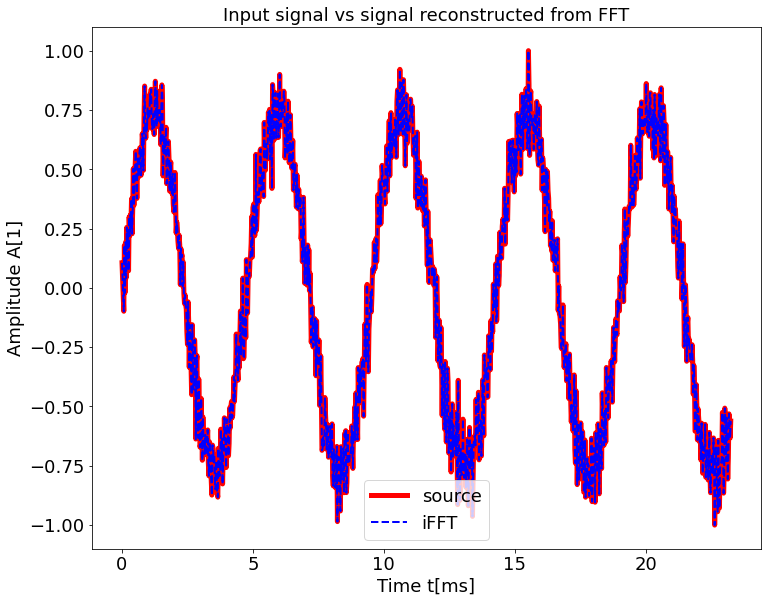

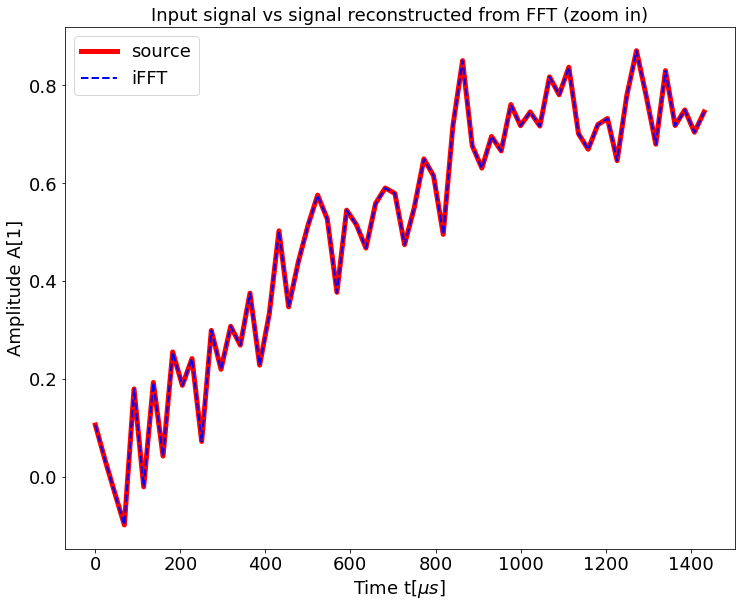

In [232]:
res_fft_cplx = res_fft_real + 1j*res_fft_imag

s = np.fft.ifft(res_fft_cplx)
plt.plot(t*1000, val, label='source', color='r', linewidth=5)
plt.plot(t*1000, s.real, '--', label='iFFT', color='b', linewidth=2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.legend(fontsize=18)
plt.xlabel("Time t[ms]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title("Input signal vs signal reconstructed from FFT", fontsize=18)
plt.show()

zoom_range = len(t)//16
plt.plot(t[:zoom_range]*1e6, val[:zoom_range], label='source', color='r', linewidth=5)
plt.plot(t[:zoom_range]*1e6, s.real[:zoom_range], '--', label='iFFT', color='b', linewidth=2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.legend(fontsize=18)
plt.xlabel(r"Time t[$\mu s$]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title("Input signal vs signal reconstructed from FFT (zoom in)", fontsize=18)
plt.show()

# References

How to use STM32 CMSIS FFT library in STM32CubeIDE's project: 
https://community.st.com/s/article/configuring-dsp-libraries-on-stm32cubeide

Documentation https://www.keil.com/pack/doc/CMSIS/DSP/html/group__ComplexFFT.html

STM32F303VCT6 https://www.st.com/en/microcontrollers-microprocessors/stm32f303vc.html
STM32F446RET6 https://www.st.com/en/microcontrollers-microprocessors/stm32f446re.html


## Testplots
Noise can be removed with simple thresholding before adding by using bins-bounds LUT.

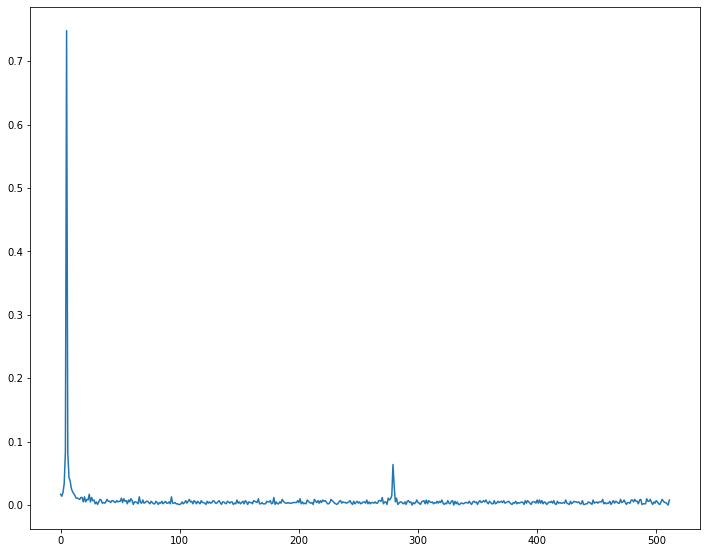

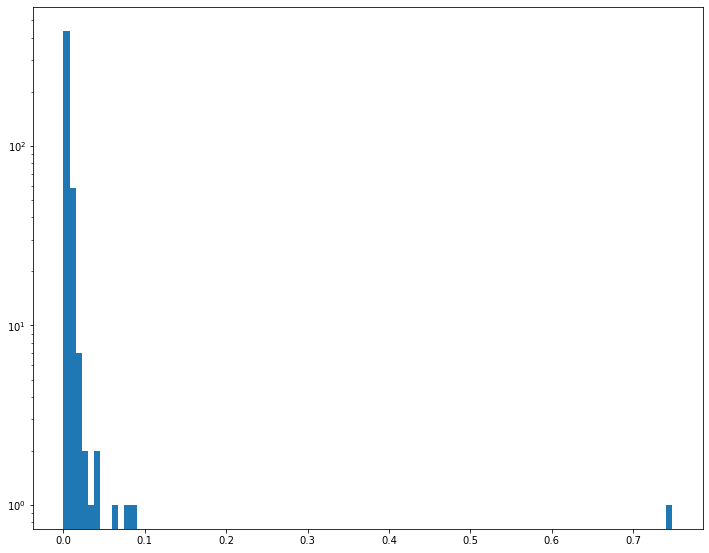

In [233]:
data = [0.017, 0.014, 0.020, 0.034, 0.084, 0.748, 0.082, 0.044, 0.038, 0.026, 0.021, 0.018, 0.015, 0.011, 0.011, 0.010, 0.009, 0.012, 0.012, 0.005, 0.013, 0.005, 0.009, 0.008, 0.017, 0.005, 0.012, 0.007, 0.008, 0.002, 0.005, 0.001, 0.005, 0.009, 0.008, 0.003, 0.004, 0.003, 0.005, 0.009, 0.006, 0.006, 0.004, 0.007, 0.007, 0.005, 0.004, 0.007, 0.005, 0.006, 0.006, 0.011, 0.004, 0.010, 0.006, 0.007, 0.002, 0.008, 0.005, 0.010, 0.007, 0.001, 0.005, 0.005, 0.004, 0.002, 0.013, 0.004, 0.003, 0.008, 0.003, 0.004, 0.006, 0.006, 0.004, 0.002, 0.006, 0.004, 0.002, 0.002, 0.006, 0.004, 0.001, 0.004, 0.003, 0.006, 0.002, 0.004, 0.006, 0.003, 0.003, 0.005, 0.002, 0.013, 0.003, 0.003, 0.004, 0.002, 0.002, 0.001, 0.001, 0.002, 0.005, 0.002, 0.004, 0.007, 0.003, 0.006, 0.009, 0.005, 0.006, 0.002, 0.007, 0.005, 0.002, 0.006, 0.004, 0.002, 0.007, 0.004, 0.004, 0.003, 0.001, 0.006, 0.003, 0.005, 0.003, 0.004, 0.007, 0.006, 0.003, 0.003, 0.005, 0.007, 0.004, 0.001, 0.005, 0.005, 0.003, 0.002, 0.006, 0.005, 0.003, 0.005, 0.005, 0.001, 0.003, 0.002, 0.008, 0.003, 0.005, 0.002, 0.004, 0.006, 0.002, 0.007, 0.005, 0.001, 0.005, 0.004, 0.004, 0.002, 0.007, 0.006, 0.005, 0.004, 0.010, 0.002, 0.002, 0.004, 0.002, 0.002, 0.002, 0.006, 0.005, 0.005, 0.007, 0.002, 0.003, 0.012, 0.001, 0.005, 0.002, 0.002, 0.005, 0.003, 0.009, 0.006, 0.004, 0.003, 0.003, 0.004, 0.003, 0.003, 0.003, 0.004, 0.004, 0.004, 0.004, 0.007, 0.004, 0.010, 0.002, 0.005, 0.002, 0.003, 0.002, 0.008, 0.006, 0.004, 0.003, 0.004, 0.001, 0.009, 0.006, 0.004, 0.007, 0.003, 0.007, 0.004, 0.008, 0.006, 0.007, 0.005, 0.002, 0.002, 0.004, 0.009, 0.007, 0.005, 0.003, 0.002, 0.001, 0.003, 0.006, 0.007, 0.003, 0.005, 0.004, 0.004, 0.003, 0.004, 0.005, 0.007, 0.003, 0.001, 0.006, 0.002, 0.004, 0.006, 0.003, 0.005, 0.002, 0.003, 0.005, 0.005, 0.003, 0.008, 0.002, 0.005, 0.002, 0.004, 0.004, 0.003, 0.005, 0.003, 0.003, 0.007, 0.007, 0.006, 0.012, 0.002, 0.005, 0.005, 0.001, 0.011, 0.008, 0.010, 0.015, 0.064, 0.029, 0.005, 0.011, 0.001, 0.003, 0.005, 0.005, 0.003, 0.002, 0.005, 0.001, 0.006, 0.007, 0.004, 0.005, 0.000, 0.004, 0.002, 0.004, 0.008, 0.004, 0.003, 0.001, 0.005, 0.006, 0.007, 0.002, 0.008, 0.002, 0.007, 0.005, 0.004, 0.005, 0.002, 0.004, 0.003, 0.006, 0.003, 0.006, 0.004, 0.008, 0.003, 0.001, 0.003, 0.002, 0.007, 0.003, 0.002, 0.006, 0.007, 0.000, 0.006, 0.002, 0.005, 0.001, 0.001, 0.003, 0.003, 0.002, 0.003, 0.004, 0.004, 0.003, 0.006, 0.003, 0.001, 0.005, 0.006, 0.004, 0.005, 0.001, 0.005, 0.007, 0.004, 0.005, 0.007, 0.005, 0.008, 0.004, 0.002, 0.006, 0.004, 0.002, 0.002, 0.007, 0.002, 0.003, 0.006, 0.004, 0.005, 0.006, 0.004, 0.007, 0.003, 0.004, 0.005, 0.006, 0.004, 0.002, 0.001, 0.004, 0.003, 0.006, 0.002, 0.004, 0.003, 0.004, 0.005, 0.004, 0.001, 0.007, 0.003, 0.007, 0.005, 0.003, 0.001, 0.005, 0.005, 0.005, 0.003, 0.008, 0.003, 0.008, 0.003, 0.007, 0.002, 0.005, 0.004, 0.001, 0.003, 0.005, 0.004, 0.006, 0.003, 0.007, 0.002, 0.001, 0.006, 0.003, 0.004, 0.003, 0.003, 0.004, 0.003, 0.008, 0.003, 0.002, 0.001, 0.006, 0.002, 0.004, 0.006, 0.005, 0.005, 0.004, 0.005, 0.002, 0.002, 0.007, 0.001, 0.001, 0.002, 0.002, 0.005, 0.004, 0.003, 0.001, 0.008, 0.003, 0.004, 0.005, 0.003, 0.005, 0.005, 0.005, 0.009, 0.002, 0.004, 0.002, 0.003, 0.003, 0.006, 0.001, 0.004, 0.007, 0.003, 0.006, 0.005, 0.003, 0.003, 0.009, 0.004, 0.005, 0.008, 0.004, 0.001, 0.004, 0.004, 0.003, 0.008, 0.008, 0.005, 0.009, 0.006, 0.006, 0.002, 0.008, 0.009, 0.001, 0.002, 0.002, 0.002, 0.010, 0.006, 0.006, 0.009, 0.004, 0.001, 0.005, 0.003, 0.007, 0.005, 0.002, 0.001, 0.005, 0.009, 0.006, 0.004, 0.004, 0.002, 0.000, 0.008]
plt.plot(data)
plt.show()

plt.yscale("log")
plt.hist(data, bins=100)
plt.show()

## Results comparison

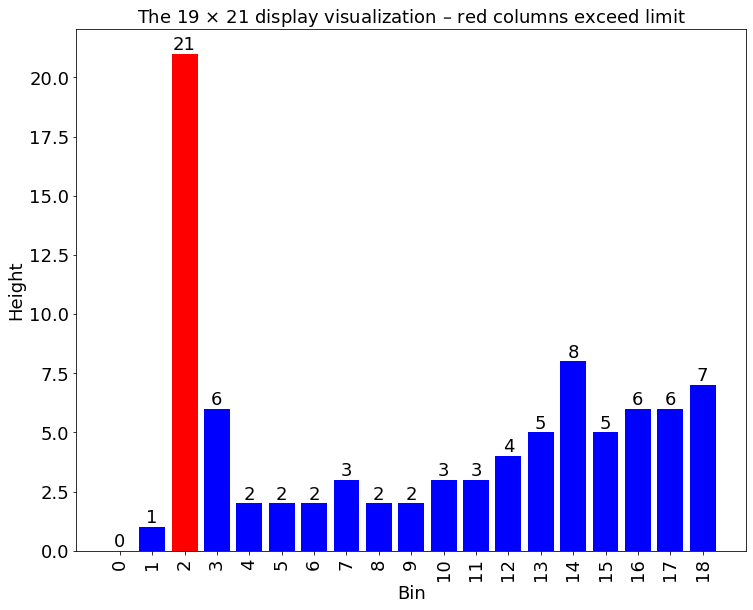

In [237]:
# columns_values = [1.099, 0.364, 0.207, 0.137, 0.120, 0.117, 0.124, 0.091, 0.109, 0.123, 0.132, 0.156, 0.173, 0.167, 0.191, 0.187, 0.206, 0.211, 0.389]
columns_values = [0.017, 0.034, 0.866, 0.229, 0.086, 0.091, 0.076, 0.110, 0.088, 0.088, 0.131, 0.136, 0.148, 0.189, 0.300, 0.195, 0.223, 0.223, 0.296]

display_gain = 25
display_height = 21

# for idx, mag in enumerate(mags):
#   columns_values[bins[idx]] += mag

heights = [cv*display_gain for cv in columns_values]

colors = ['blue' if height_v < display_height else 'red' for height_v in heights]
heights = [round(min(height_v, display_height)) for height_v in heights]

bars = plt.bar([str(i) for i in range(bands_count)], heights, color=colors)

for rect in bars:
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom', fontsize=18)

plt.xticks(fontsize= 18, rotation=90)
plt.yticks(fontsize= 18)
plt.title(f"The {bands_count} " + r"$\times$" + f" {display_height} display visualization – red columns exceed limit", fontsize=18)
plt.ylabel('Height', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()

## Noise removal
Values below about 0.05 can be thresholded
```
static void mags_to_bounds() {
	for(int i = 0; i < 19; i++)
		bounds_heights[i] = 0;

	for(int i = 0; i < 512; i++) {
		if(usable_magnitudes[i] > 0.025)
			bounds_heights[bins[i]] += usable_magnitudes[i];
	}
}
```


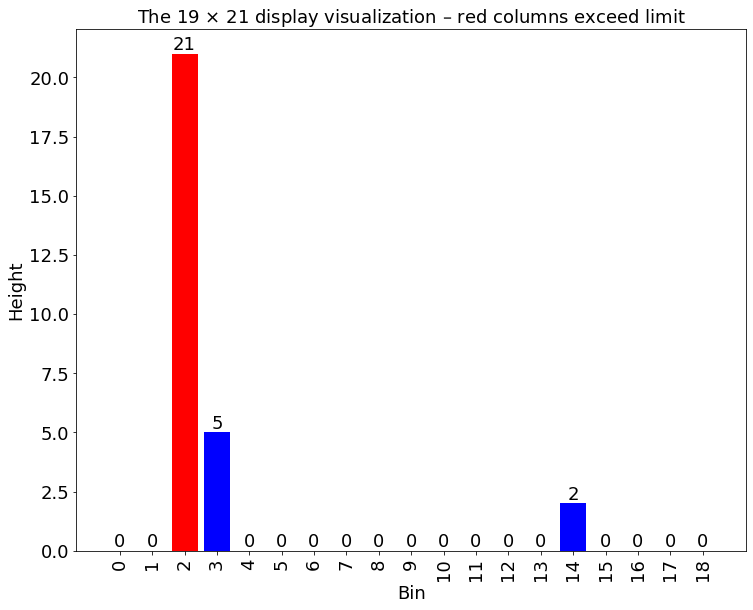

In [236]:
columns_values_thres = [0.000, 0.020, 0.866, 0.212, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.093, 0.000, 0.000, 0.000, 0.000]

display_gain = 25
display_height = 21

# for idx, mag in enumerate(mags):
#   columns_values_thres[bins[idx]] += mag

heights = [cv*display_gain for cv in columns_values_thres]

colors = ['blue' if height_v < display_height else 'red' for height_v in heights]
heights = [round(min(height_v, display_height)) for height_v in heights]

bars = plt.bar([str(i) for i in range(bands_count)], heights, color=colors)

for rect in bars:
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom', fontsize=18)

plt.xticks(fontsize= 18, rotation=90)
plt.yticks(fontsize= 18)
plt.title(f"The {bands_count} " + r"$\times$" + f" {display_height} display visualization – red columns exceed limit", fontsize=18)
plt.ylabel('Height', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()

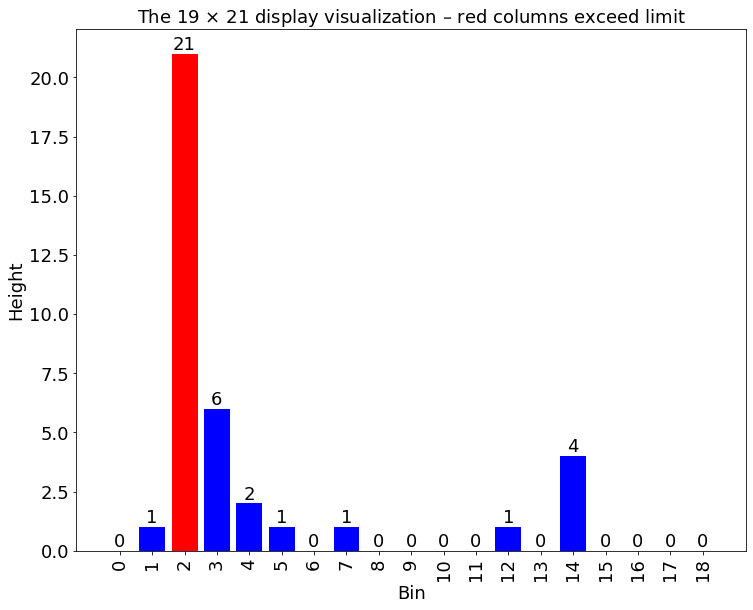

In [239]:
columns_values_thres = [0.017, 0.034, 0.866, 0.229, 0.072, 0.042, 0.000, 0.031, 0.013, 0.013, 0.000, 0.000, 0.022, 0.000, 0.151, 0.000, 0.000, 0.000, 0.000,]

display_gain = 25
display_height = 21

# for idx, mag in enumerate(mags):
#   columns_values_thres[bins[idx]] += mag

heights = [cv*display_gain for cv in columns_values_thres]

colors = ['blue' if height_v < display_height else 'red' for height_v in heights]
heights = [round(min(height_v, display_height)) for height_v in heights]

bars = plt.bar([str(i) for i in range(bands_count)], heights, color=colors)

for rect in bars:
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom', fontsize=18)

plt.xticks(fontsize= 18, rotation=90)
plt.yticks(fontsize= 18)
plt.title(f"The {bands_count} " + r"$\times$" + f" {display_height} display visualization – red columns exceed limit", fontsize=18)
plt.ylabel('Height', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()

## Test signal - results

Seems working. 2 spikes are clearly visible.

## Testing with DAC

Now there will be done test using built in DAC. Sine wave will ge ganeretad and output with DAC to get 1kHz.
Check another notebook with [Sine Generation](../ASD_STM32F4/Notebooks/ASD_sine_generator.ipynb)

![128 DAC samples](../ASD_STM32F4/Notebooks/samples_128.png)